# Stock Portfolio Optimization Project

<span style="color:blue;font-weight:bold;font-size:26px">Data Preparation</span>

In [54]:
import yfinance as yf
import pandas as pd

# Define the date range
start_date = '2014-05-01'
end_date = '2024-04-30'

# Define the updated list of stocks for each industry
industries = {
    'Renewable Energy': ['TSLA', 'NEE', 'ENPH', 'FSLR', 'CSIQ', 'BEP'],
    'Finance': ['JPM', 'BLK', 'V', 'GS', 'MS', 'MA'],
    'Artificial Intelligence and Technology': ['NVDA', 'AMD', 'MSFT', 'GOOGL', 'AMZN', 'AAPL'],
    'Biotechnology': ['REGN', 'GILD', 'AMGN', 'VRTX', 'BIIB', 'ILMN'],
    'Consumer Staples': ['PG', 'KO', 'PEP', 'WMT', 'CL', 'COST'],
    'Commodities': ['BHP', 'RIO', 'VALE', 'FCX', 'GOLD', 'NEM'],
    'Health Technology': ['ISRG', 'SYK', 'TMO', 'MDT', 'DHR', 'ABT'],
    'Emerging Markets': ['PBR', 'TCEHY', 'MELI', 'INFY', 'BIDU', 'NTES'],
    'Real Estate':['AMT','PLD','CCI','PSA','EQIX','SPG'],
    'Industry':['HON','UNP','CAT','DE','MMM','LMT']
}

# Initialize a list to store stocks that do not meet the date criteria
stocks_not_meeting_criteria = []

# Check each stock for the date range
for industry, tickers in industries.items():
    for ticker in tickers:
        data = yf.download(ticker, start=start_date, end=end_date)['Adj Close']
        if data.index.min() > pd.to_datetime(start_date):
            stocks_not_meeting_criteria.append(ticker)
            print(f"{ticker} does not have data starting from {start_date}")

print("Stocks that do not meet the date criteria (starting from 2014-05-01):")
print(stocks_not_meeting_criteria)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

<span style="color:red;font-weight:bold;font-size:22px">Data Loading and Cleaning</span>

In [55]:
import numpy as np
import os

# Create directory to save CSV files if it doesn't exist
if not os.path.exists('stock_data'):
    os.makedirs('stock_data')

# Create industry directories if they don't exist
for industry in industries.keys():
    industry_dir = f'stock_data/{industry.replace(" ", "_")}'
    if not os.path.exists(industry_dir):
        os.makedirs(industry_dir)

# Download the data and resample to monthly frequency
for industry, tickers in industries.items():
    industry_dir = f'stock_data/{industry.replace(" ", "_")}'
    for ticker in tickers:
        data = yf.download(ticker, start=start_date, end=end_date)['Adj Close']
        data = data.resample('M').last()  # Resample to monthly data
        
        # Handle missing values by forward filling
        data = data.ffill()
        
        # Calculate monthly log returns
        log_returns = np.log(data / data.shift(1)).dropna()
        
        # Save to CSV in the respective industry directory
        log_returns.to_csv(f'{industry_dir}/{ticker}_monthly_log_returns.csv', header=['Log Return'])

# Load datasets and extract 'Log Return' data
data_files = {ticker: f'stock_data/{industry.replace(" ", "_")}/{ticker}_monthly_log_returns.csv' for industry, tickers in industries.items() for ticker in tickers}
returns_data = {name: pd.read_csv(path)['Log Return'].dropna().squeeze() for name, path in data_files.items()}

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

<span style="color:blue;font-weight:bold;font-size:26px">Industry and Stock Selection</span>

<span style="color:red;font-weight:bold;font-size:22px">Evaluate and Select Top Industries</span>

I will evaluate and select the top 5 performing industries based on the following performance metrics:  

Annual Return: Average annualized return of the stocks in each industry.  
Volatility: Standard deviation of the returns, annualized.  
Sharpe Ratio: Ratio of annual return to annual volatility, indicating risk-adjusted performance.  
Skew: Measures the asymmetry of the return distribution, indicating whether returns are more likely to be higher or lower than the mean.  
Kurtosis: Measures the “tailedness” of the return distribution, indicating the likelihood of extreme returns compared to a normal distribution.  

In [56]:
from scipy.stats import skew, kurtosis

# Define a function to calculate annual return and volatility for individual stocks
def calculate_individual_metrics(log_returns):
    annual_return = log_returns.mean() * 12  # Annualize the average monthly return
    annual_volatility = log_returns.std() * np.sqrt(12)  # Annualize the monthly volatility
    sharpe_ratio = annual_return / annual_volatility
    return annual_return, annual_volatility, sharpe_ratio

# Define a function to calculate industry performance metrics
def calculate_industry_metrics(industry, tickers):
    industry_annual_returns = []
    industry_annual_volatilities = []
    industry_sharpe_ratios = []
    industry_skewnesses = []
    industry_kurtoses = []

    industry_dir = f'stock_data/{industry.replace(" ", "_")}'

    for ticker in tickers:
        data = pd.read_csv(f'{industry_dir}/{ticker}_monthly_log_returns.csv', index_col=0, parse_dates=True)
        annual_return, annual_volatility, sharpe_ratio = calculate_individual_metrics(data['Log Return'])
        industry_annual_returns.append(annual_return)
        industry_annual_volatilities.append(annual_volatility)
        industry_sharpe_ratios.append(sharpe_ratio)
        industry_skewnesses.append(skew(data['Log Return']))
        industry_kurtoses.append(kurtosis(data['Log Return']))

    # Calculate the average for each metric
    avg_annual_return = np.mean(industry_annual_returns)
    avg_annual_volatility = np.mean(industry_annual_volatilities)
    avg_sharpe_ratio = np.mean(industry_sharpe_ratios)
    avg_skewness = np.mean(industry_skewnesses)
    avg_kurtosis = np.mean(industry_kurtoses)

    return {
        'Annual Return': avg_annual_return,
        'Volatility': avg_annual_volatility,
        'Sharpe Ratio': avg_sharpe_ratio,
        'Skewness': avg_skewness,
        'Kurtosis': avg_kurtosis
    }

# Calculate performance metrics for each industry
industry_performance = {}

for industry, tickers in industries.items():
    industry_performance[industry] = calculate_industry_metrics(industry, tickers)

# Convert to DataFrame for better visualization
industry_performance_df = pd.DataFrame(industry_performance).T

# Print summary statistics
for industry, metrics in industry_performance.items():
    print(f"Summary Statistics for {industry}:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.2f}")
    print()

# Save the industry performance data to a CSV file
industry_performance_df.to_csv('industry_performance_metrics.csv')

Summary Statistics for Renewable Energy:
Annual Return: 0.13
Volatility: 0.48
Sharpe Ratio: 0.32
Skewness: 0.03
Kurtosis: 0.42

Summary Statistics for Finance:
Annual Return: 0.15
Volatility: 0.25
Sharpe Ratio: 0.61
Skewness: -0.29
Kurtosis: 0.48

Summary Statistics for Artificial Intelligence and Technology:
Annual Return: 0.30
Volatility: 0.34
Sharpe Ratio: 0.90
Skewness: -0.21
Kurtosis: 0.27

Summary Statistics for Biotechnology:
Annual Return: 0.06
Volatility: 0.30
Sharpe Ratio: 0.21
Skewness: -0.00
Kurtosis: 0.76

Summary Statistics for Consumer Staples:
Annual Return: 0.11
Volatility: 0.17
Sharpe Ratio: 0.62
Skewness: -0.41
Kurtosis: 0.56

Summary Statistics for Commodities:
Annual Return: 0.06
Volatility: 0.41
Sharpe Ratio: 0.17
Skewness: 0.05
Kurtosis: 0.33

Summary Statistics for Health Technology:
Annual Return: 0.15
Volatility: 0.22
Sharpe Ratio: 0.66
Skewness: -0.20
Kurtosis: 0.15

Summary Statistics for Emerging Markets:
Annual Return: 0.14
Volatility: 0.40
Sharpe Ratio: 0

<span style="color:red; font-weight:bold; font-size:22px">Visualize Industry Performance Metrics</span>

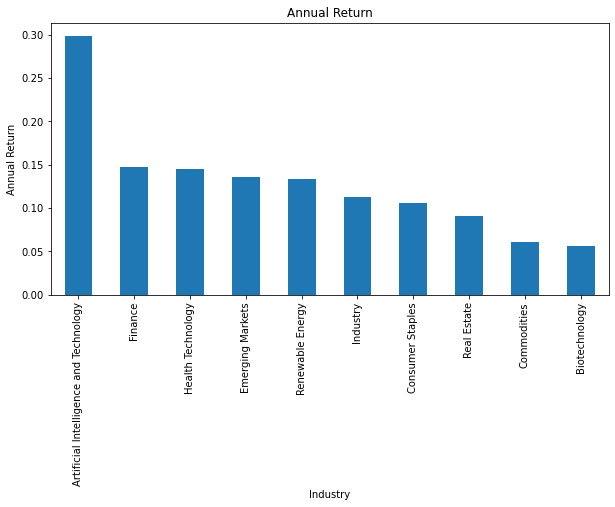

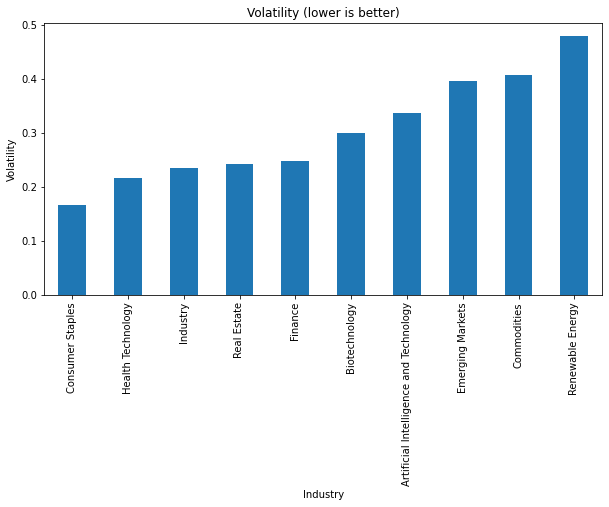

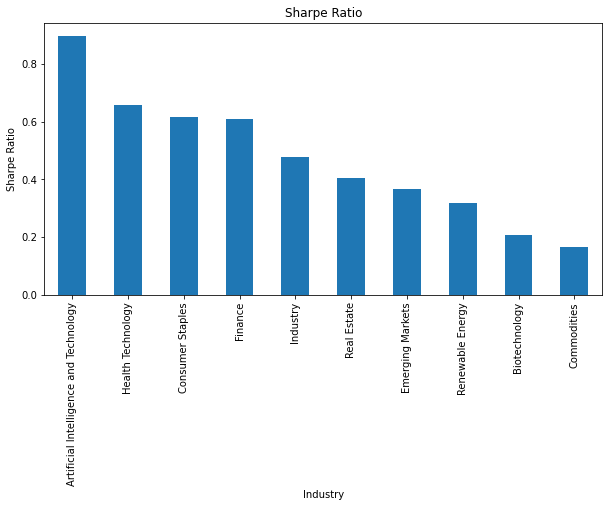

In [57]:
import matplotlib.pyplot as plt

# Plot the performance of each industry in separate plots

# Annual Return
plt.figure(figsize=(10, 5))
annual_return_sorted = industry_performance_df['Annual Return'].sort_values(ascending=False)
annual_return_sorted.plot(kind='bar')
plt.title('Annual Return')
plt.ylabel('Annual Return')
plt.xlabel('Industry')
plt.show()

# Volatility (inverse order)
plt.figure(figsize=(10, 5))
volatility_sorted = industry_performance_df['Volatility'].sort_values(ascending=True)
volatility_sorted.plot(kind='bar')
plt.title('Volatility (lower is better)')
plt.ylabel('Volatility')
plt.xlabel('Industry')
plt.show()

# Sharpe Ratio
plt.figure(figsize=(10, 5))
sharpe_ratio_sorted = industry_performance_df['Sharpe Ratio'].sort_values(ascending=False)
sharpe_ratio_sorted.plot(kind='bar')
plt.title('Sharpe Ratio')
plt.ylabel('Sharpe Ratio')
plt.xlabel('Industry')
plt.show()

<span style="color:red; font-weight:bold;font-size:22px">Select Top 5 Industries from These 10 Industries</span>

In [58]:
from collections import Counter

# Sort by different metrics
top_sharpe_ratio_industries = industry_performance_df.sort_values(by='Sharpe Ratio', ascending=False).head(5)
top_annual_return_industries = industry_performance_df.sort_values(by='Annual Return', ascending=False).head(5)
top_volatility_industries = industry_performance_df.sort_values(by='Volatility', ascending=True).head(5)

# Combine results
combined_industries = pd.concat([top_sharpe_ratio_industries, top_annual_return_industries, top_volatility_industries])

# Count occurrences of each industry
industry_counts = Counter(combined_industries.index)

# Find the top 5 industries based on occurrences
most_common_industries = industry_counts.most_common(5)

# Output the top 5 industries
print("Top 5 Industries by Occurrences:")
for industry, count in most_common_industries:
    print(f"{industry}: {count} occurrences")

Top 5 Industries by Occurrences:
Health Technology: 3 occurrences
Finance: 3 occurrences
Artificial Intelligence and Technology: 2 occurrences
Consumer Staples: 2 occurrences
Industry: 2 occurrences


<span style="color: blue; font-weight: bold; font-size: 26px;">Modeling and Analysis</span>

<span style="color:red; font-weight:bold; font-size:22px">Download SPY Data</span>

In [6]:
import statsmodels.api as sm
from scipy.optimize import minimize
from arch import arch_model


# Define the date range
start_date = '2014-05-01'
end_date = '2024-04-30'

# Download SPY data
spy_data = yf.download('SPY', start=start_date, end=end_date)['Adj Close']
spy_returns = spy_data.pct_change().dropna().apply(lambda x: np.log(1 + x))

# Save SPY returns
spy_returns.to_csv('stock_data/SPY_data.csv', header=['SPY Return'])

# Load saved SPY data
market_returns = pd.read_csv('stock_data/SPY_data.csv', index_col=0, parse_dates=True)['SPY Return']
selected_stocks = {}

[*********************100%***********************]  1 of 1 completed


<span style="color:red; font-weight:bold; font-size:22px">CAPM</span>

In [7]:
import statsmodels.api as sm
import os

# Define the date range
start_date = '2014-05-01'
end_date = '2024-04-30'

# Define risk-free rate (for example, using the average risk-free rate over the period)
risk_free_rate = 0.02  # Example risk-free rate, adjust as needed

# Define industries and their top stocks
top5_industries = {
    'Artificial Intelligence and Technology': ['NVDA', 'AMD', 'MSFT', 'GOOGL', 'AMZN', 'AAPL'],
    'Health Technology': ['ISRG', 'SYK', 'TMO', 'MDT', 'DHR', 'ABT'],
    'Consumer Staples': ['PG', 'KO', 'PEP', 'WMT', 'CL', 'COST'],
    'Finance': ['JPM', 'BLK', 'V', 'GS', 'MS', 'MA'],
    'Industry': ['HON', 'UNP', 'CAT', 'DE', 'MMM', 'LMT']
}

# Define a function to calculate Beta using linear regression
def calculate_beta(stock_returns, market_returns):
    # Align and drop NaN values in one step
    aligned_data = pd.concat([stock_returns, market_returns], axis=1).dropna()
    
    # Check if the aligned data is empty
    if aligned_data.empty:
        raise ValueError("The aligned data is empty after dropping NaN values.")
    
    # Add constant to market returns and run regression
    X = sm.add_constant(aligned_data.iloc[:, 1])  # Market returns with constant
    y = aligned_data.iloc[:, 0]  # Stock returns
    model = sm.OLS(y, X).fit()
    beta = model.params[1]
    return beta

# Define a function to calculate expected return using CAPM
def calculate_capm_return(beta, risk_free_rate, market_return):
    return risk_free_rate + beta * (market_return - risk_free_rate)

# Initialize dictionary to store selected stocks and their expected returns
selected_stocks = {}

# Load the returns data
returns_data = {}
for industry, tickers in top5_industries.items():
    industry_dir = f'stock_data/{industry.replace(" ", "_")}'
    for ticker in tickers:
        file_path = f'{industry_dir}/{ticker}_monthly_log_returns.csv'
        if os.path.exists(file_path):
            returns_data[ticker] = pd.read_csv(file_path, index_col=0, parse_dates=True)['Log Return'].dropna()
        else:
            print(f"File not found: {file_path}")

# Initialize a dictionary to store expected returns for each industry
expected_returns = {industry: [] for industry in top5_industries.keys()}

# Load market returns and filter by date range
market_returns = pd.read_csv('stock_data/SPY_data.csv', index_col=0, parse_dates=True)['SPY Return']
market_returns = market_returns[(market_returns.index >= start_date) & (market_returns.index <= end_date)]

# Calculate CAPM expected returns for each stock
for industry, tickers in top5_industries.items():
    industry_returns = {}
    
    for ticker in tickers:
        if ticker in returns_data:
            stock_returns = returns_data[ticker]
            try:
                beta = calculate_beta(stock_returns, market_returns)
                expected_return = calculate_capm_return(beta, risk_free_rate, market_returns.mean())
                industry_returns[ticker] = expected_return
                expected_returns[industry].append((ticker, expected_return))
            except ValueError as e:
                print(f"Error calculating for {ticker}: {e}")

print("Expected returns for each industry:")
for industry, returns in expected_returns.items():
    print(f"{industry}: {returns}")

Expected returns for each industry:
Artificial Intelligence and Technology: [('NVDA', -0.003122084906899726), ('AMD', 0.001853869432615684), ('MSFT', 0.005012475161119901), ('GOOGL', 0.005549449191502392), ('AMZN', 0.012693139586883147), ('AAPL', 0.003621606165114786)]
Health Technology: [('ISRG', 0.011466107538425255), ('SYK', 0.0021175736739321195), ('TMO', 0.0018118751825572238), ('MDT', 0.016981014935003716), ('DHR', 0.006242469407528069), ('ABT', 0.010926206756110996)]
Consumer Staples: [('PG', -0.015448605040647493), ('KO', -0.014997138706080309), ('PEP', -0.0006365198494790031), ('WMT', -0.003212746796237946), ('CL', 0.0017643354504805753), ('COST', 0.017214388895228694)]
Finance: [('JPM', -0.0017851714797023077), ('BLK', -0.008413456608068668), ('V', 0.0026258389177205993), ('GS', -0.002167251465267528), ('MS', -0.01911774982927063), ('MA', -0.004153960996877343)]
Industry: [('HON', -0.010335656199831861), ('UNP', -0.0119895490724878), ('CAT', -0.015837197139671546), ('DE', -0.

<span style="color:red; font-weight:bold; font-size:22px">Industries CAPM Visualization</span>

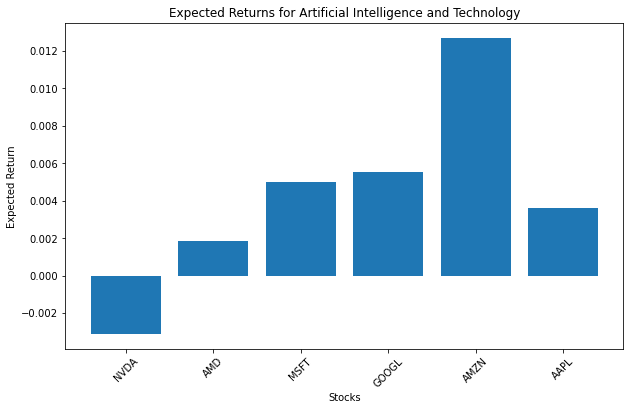

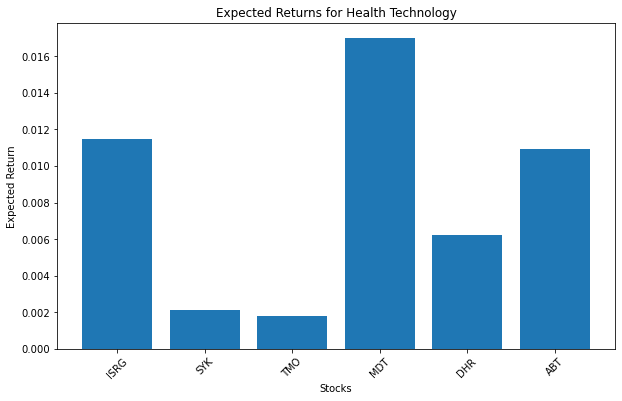

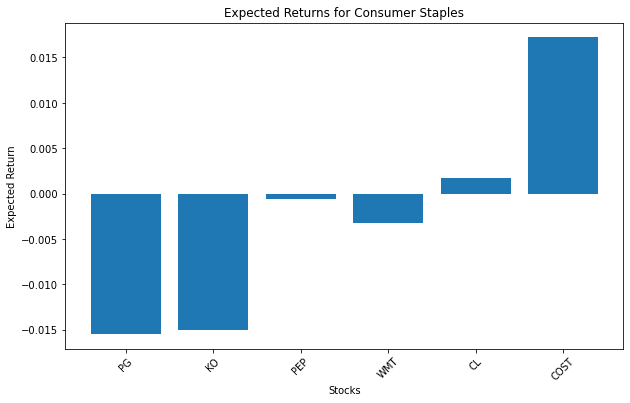

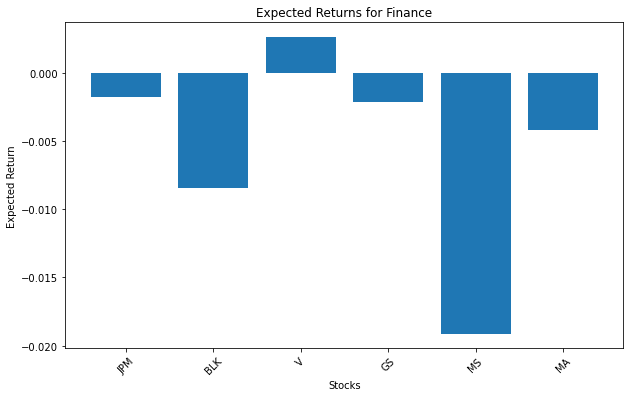

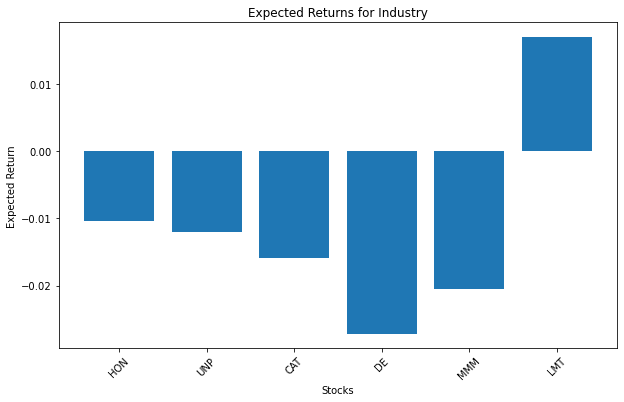

In [8]:
selected_stocks[industry] = industry_returns

# Plot the expected returns for each industry
for industry, returns in expected_returns.items():
    if returns:  # Check if there are returns to plot
        tickers, values = zip(*returns)
        plt.figure(figsize=(10, 6))
        plt.bar(tickers, values)
        plt.xlabel('Stocks')
        plt.ylabel('Expected Return')
        plt.title(f'Expected Returns for {industry}')
        plt.xticks(rotation=45)
        plt.show()
    else:
        print(f"No returns to plot for {industry}")

<span style="color: red; font-weight: bold; font-size: 22px;">ACF and PACF Analysis for Autocorrelation</span>

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from arch import arch_model
from statsmodels.tsa.stattools import acf, pacf
import matplotlib.pyplot as plt
import numpy as np

# Initialize a list to store the names of stocks to be excluded
excluded_stocks = []

# Function to check for significant autocorrelations
def check_autocorrelation(name, returns):
    sample_size = len(returns)
    max_lags = min(20, sample_size // 2 - 1)  # Ensure max_lags does not exceed 50% of sample size
    
    # Get the number of significant lags in ACF and PACF
    acf_values = acf(returns, nlags=max_lags)
    pacf_values = pacf(returns, nlags=max_lags)
    significant_acf_lags = np.sum(np.abs(acf_values[1:]) > 1.96 / np.sqrt(len(returns)))
    significant_pacf_lags = np.sum(np.abs(pacf_values[1:]) > 1.96 / np.sqrt(len(returns)))
    
    print(f"{name}: {significant_acf_lags} significant lags in ACF, {significant_pacf_lags} significant lags in PACF")
    
    # Check for significant autocorrelations
    if significant_acf_lags > 2 or significant_pacf_lags > 2:
        print(f'{name} shows significant autocorrelation.')
        return True
    else:
        return False

# Loop through each stock's returns and check for significant autocorrelation
for name, returns in returns_data.items():
    if check_autocorrelation(name, returns):
        excluded_stocks.append(name)

print("Excluded stocks based on ACF and PACF analysis:", excluded_stocks)

NVDA: 0 significant lags in ACF, 0 significant lags in PACF
AMD: 0 significant lags in ACF, 0 significant lags in PACF
MSFT: 1 significant lags in ACF, 1 significant lags in PACF
GOOGL: 3 significant lags in ACF, 4 significant lags in PACF
GOOGL shows significant autocorrelation.
AMZN: 0 significant lags in ACF, 0 significant lags in PACF
AAPL: 0 significant lags in ACF, 0 significant lags in PACF
ISRG: 1 significant lags in ACF, 1 significant lags in PACF
SYK: 6 significant lags in ACF, 7 significant lags in PACF
SYK shows significant autocorrelation.
TMO: 0 significant lags in ACF, 0 significant lags in PACF
MDT: 0 significant lags in ACF, 1 significant lags in PACF
DHR: 0 significant lags in ACF, 0 significant lags in PACF
ABT: 0 significant lags in ACF, 0 significant lags in PACF
PG: 1 significant lags in ACF, 1 significant lags in PACF
KO: 2 significant lags in ACF, 2 significant lags in PACF
PEP: 1 significant lags in ACF, 2 significant lags in PACF
WMT: 0 significant lags in ACF

ANALYSIS:  
Based on the ACF and PACF analysis, the stocks 'GOOGL', 'SYK', 'COST','V', and 'MA' exhibit significant autocorrelations. This indicates that these stocks have more predictable patterns in their returns, which could be advantageous for certain trading strategies that capitalize on these autocorrelations. However, for our portfolio, we need to carefully consider their inclusion as they might introduce additional risks if the autocorrelation signals are driven by market inefficiencies or anomalies.

<span style="color:red;font-weight:bold;font-size:22px">Plot ACF AND PACF</span>

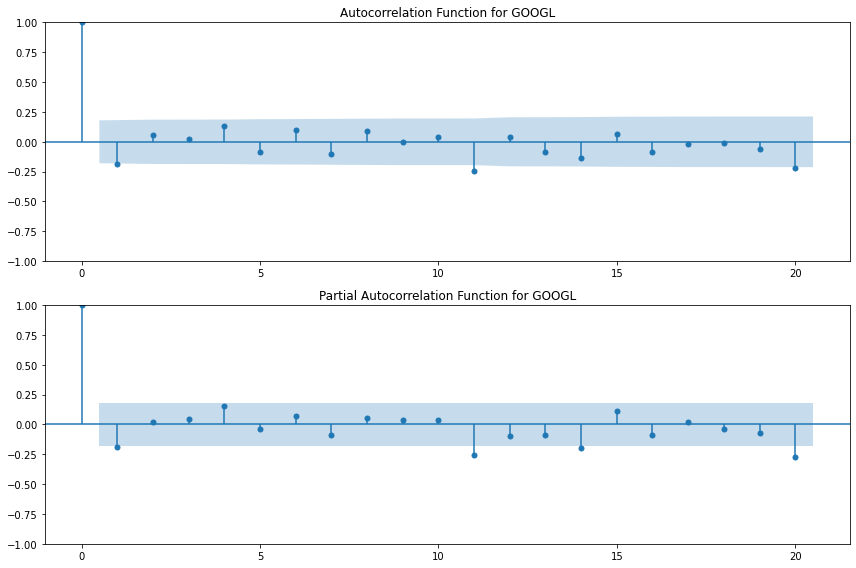

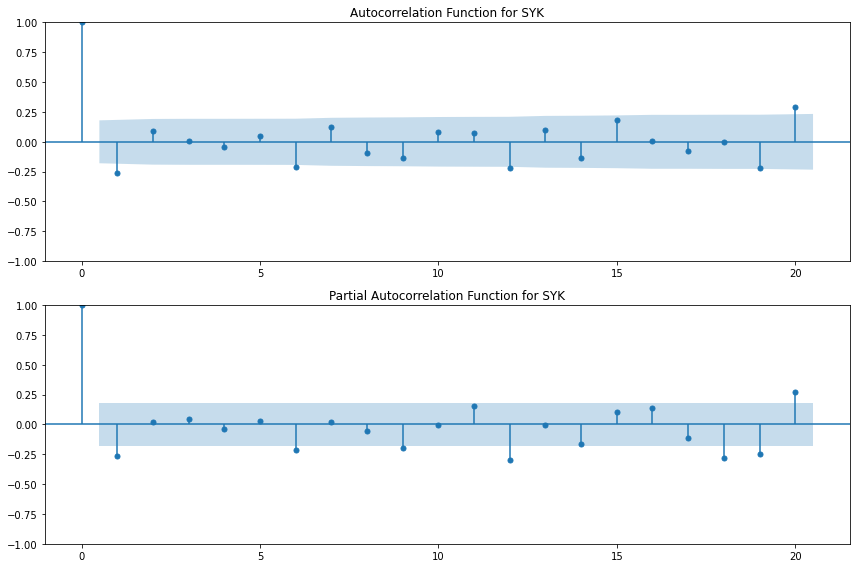

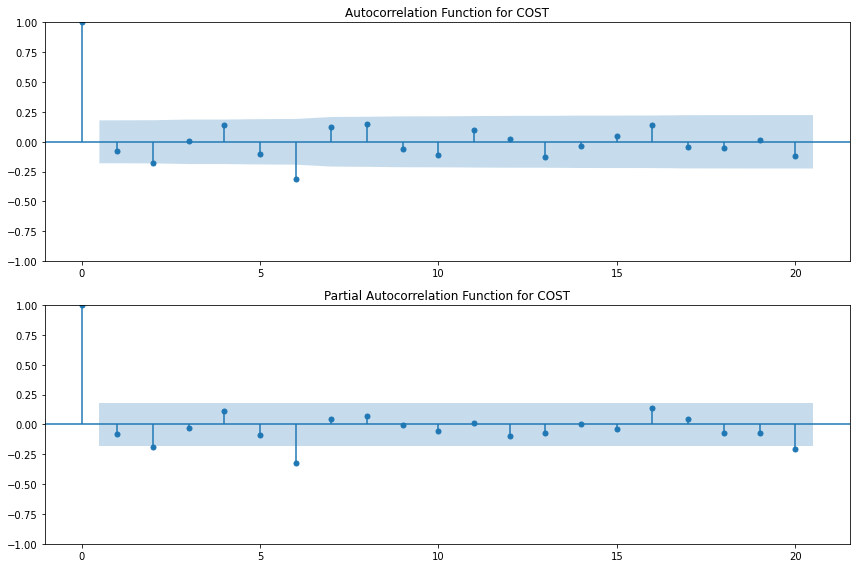

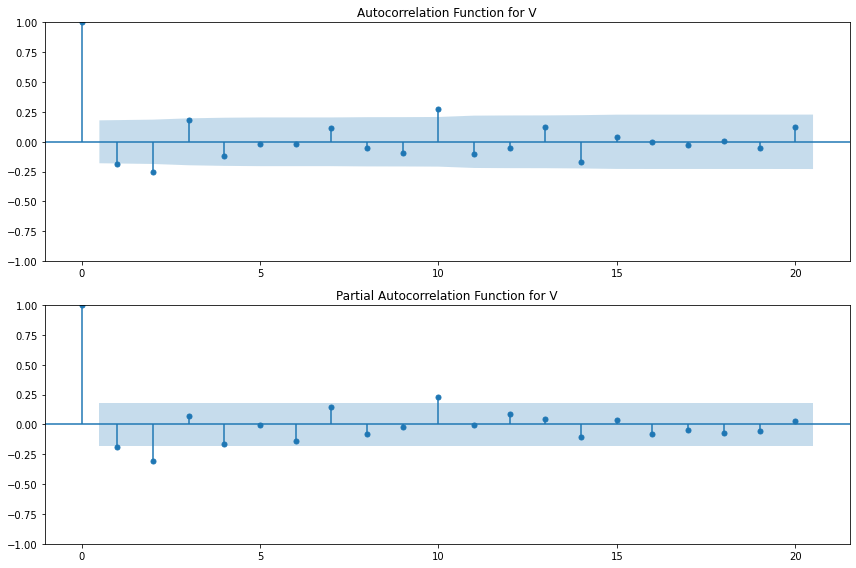

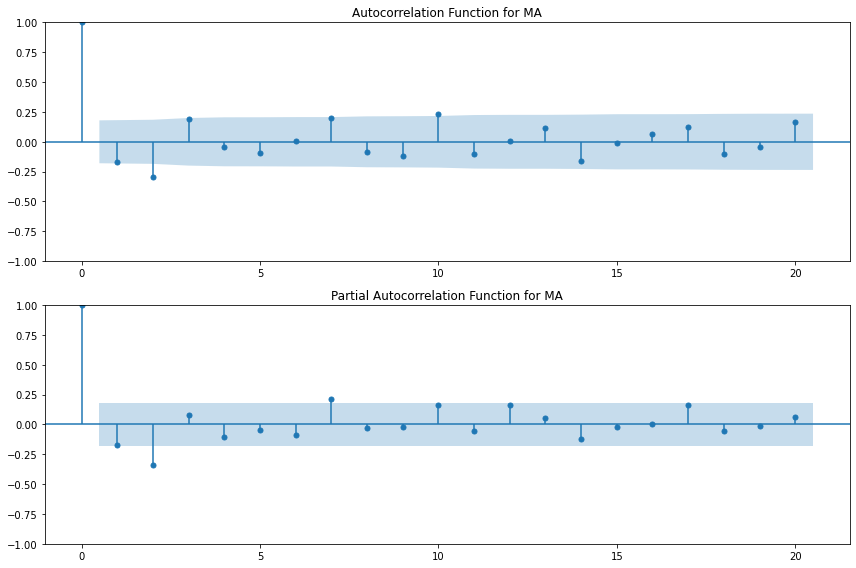

In [62]:
# Plot ACF and PACF for stocks that show significant autocorrelation
import warnings
warnings.filterwarnings("ignore")

for name in excluded_stocks:
    returns = returns_data[name]
    sample_size = len(returns)
    max_lags = min(20, sample_size // 2 - 1)  # Ensure max_lags does not exceed 50% of sample size
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    
    plot_acf(returns, lags=max_lags, ax=ax1)  # Adjust the number of lags as needed
    ax1.set_title(f'Autocorrelation Function for {name}')
    
    plot_pacf(returns, lags=max_lags, ax=ax2)  # Adjust the number of lags as needed
    ax2.set_title(f'Partial Autocorrelation Function for {name}')
    
    plt.tight_layout()
    plt.show()

<span style="color:red; font-weight:bold; font-size:22px">GARCH model fitting with Q-Q diagram</span>

Results for TSLA
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                   Log Return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                53.2574
Distribution:      Standardized Student's t   AIC:                          -96.5149
Method:                  Maximum Likelihood   BIC:                          -82.6193
                                              No. Observations:                  119
Date:                      Sat, Jun 01 2024   Df Residuals:                      118
Time:                              01:25:38   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
--------------------------------------------------------------

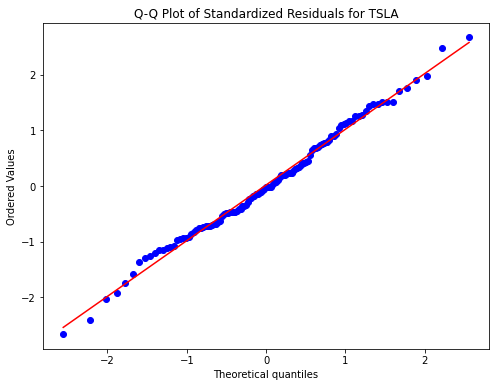

Results for NEE
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                   Log Return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                176.249
Distribution:      Standardized Student's t   AIC:                          -342.498
Method:                  Maximum Likelihood   BIC:                          -328.602
                                              No. Observations:                  119
Date:                      Sat, Jun 01 2024   Df Residuals:                      118
Time:                              01:25:38   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
-----------------------------------------------------------------

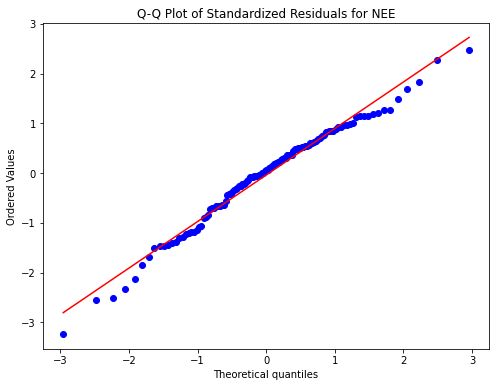

Results for ENPH
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                   Log Return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               0.698458
Distribution:      Standardized Student's t   AIC:                           8.60308
Method:                  Maximum Likelihood   BIC:                           22.4987
                                              No. Observations:                  119
Date:                      Sat, Jun 01 2024   Df Residuals:                      118
Time:                              01:25:38   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
--------------------------------------------------------------

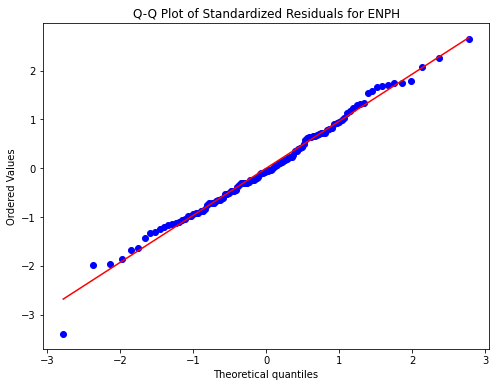

Results for FSLR
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                   Log Return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                69.1185
Distribution:      Standardized Student's t   AIC:                          -128.237
Method:                  Maximum Likelihood   BIC:                          -114.341
                                              No. Observations:                  119
Date:                      Sat, Jun 01 2024   Df Residuals:                      118
Time:                              01:25:38   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
--------------------------------------------------------------

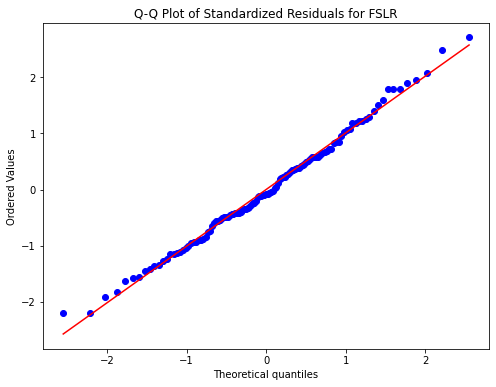

Results for CSIQ
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                   Log Return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                51.1365
Distribution:      Standardized Student's t   AIC:                          -92.2731
Method:                  Maximum Likelihood   BIC:                          -78.3775
                                              No. Observations:                  119
Date:                      Sat, Jun 01 2024   Df Residuals:                      118
Time:                              01:25:38   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------

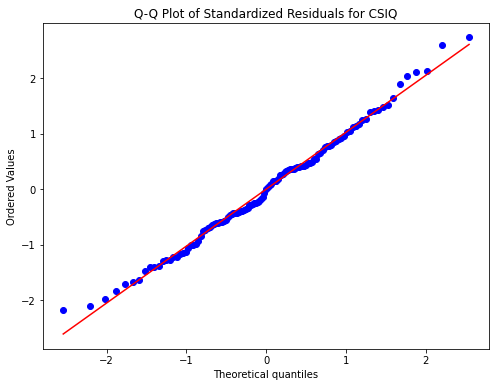

Results for BEP
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                   Log Return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                162.477
Distribution:      Standardized Student's t   AIC:                          -314.953
Method:                  Maximum Likelihood   BIC:                          -301.058
                                              No. Observations:                  119
Date:                      Sat, Jun 01 2024   Df Residuals:                      118
Time:                              01:25:38   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
---------------------------------------------------------------

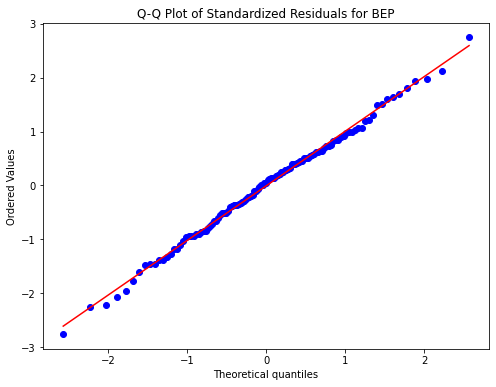

Results for JPM
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                   Log Return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                152.153
Distribution:      Standardized Student's t   AIC:                          -294.306
Method:                  Maximum Likelihood   BIC:                          -280.410
                                              No. Observations:                  119
Date:                      Sat, Jun 01 2024   Df Residuals:                      118
Time:                              01:25:38   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
-----------------------------------------------------------------

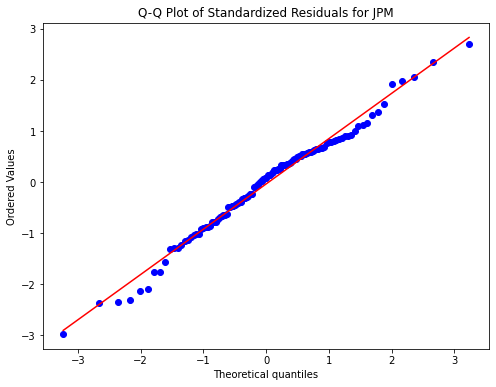

Results for BLK
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                   Log Return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                146.348
Distribution:      Standardized Student's t   AIC:                          -282.696
Method:                  Maximum Likelihood   BIC:                          -268.800
                                              No. Observations:                  119
Date:                      Sat, Jun 01 2024   Df Residuals:                      118
Time:                              01:25:38   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
---------------------------------------------------------------

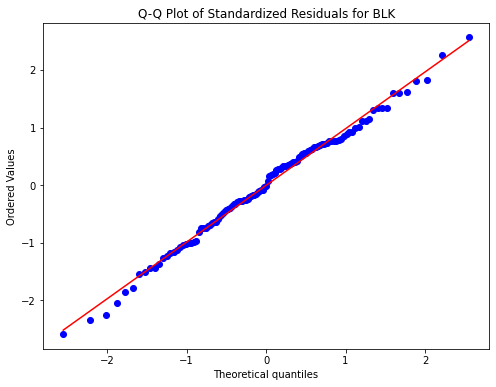

Results for V
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                   Log Return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                174.764
Distribution:      Standardized Student's t   AIC:                          -339.528
Method:                  Maximum Likelihood   BIC:                          -325.633
                                              No. Observations:                  119
Date:                      Sat, Jun 01 2024   Df Residuals:                      118
Time:                              01:25:39   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
-------------------------------------------------------------------

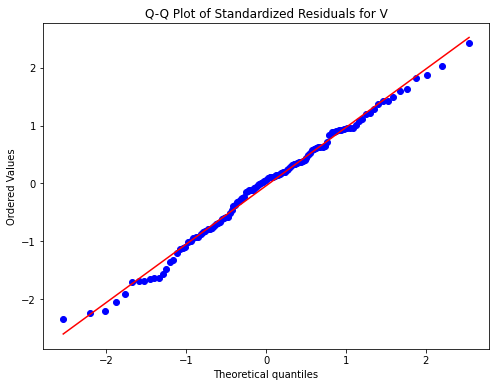

Results for GS
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                   Log Return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                137.706
Distribution:      Standardized Student's t   AIC:                          -265.411
Method:                  Maximum Likelihood   BIC:                          -251.516
                                              No. Observations:                  119
Date:                      Sat, Jun 01 2024   Df Residuals:                      118
Time:                              01:25:39   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
----------------------------------------------------------------

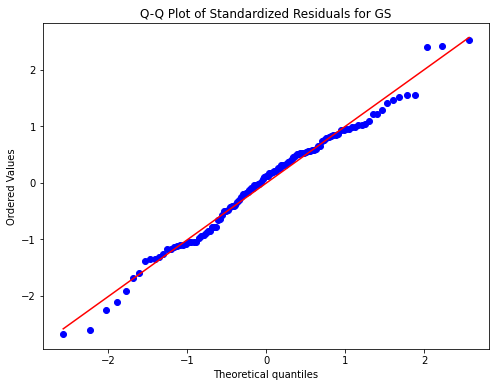

Results for MS
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                   Log Return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                129.401
Distribution:      Standardized Student's t   AIC:                          -248.802
Method:                  Maximum Likelihood   BIC:                          -234.906
                                              No. Observations:                  119
Date:                      Sat, Jun 01 2024   Df Residuals:                      118
Time:                              01:25:39   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
----------------------------------------------------------------

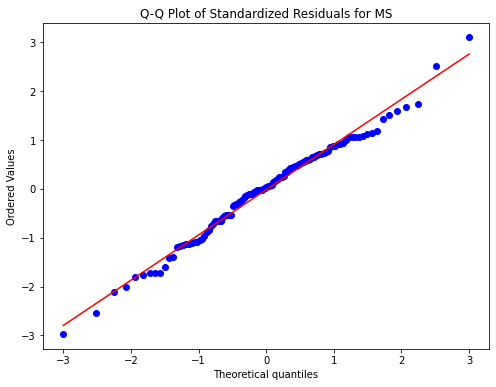

Results for MA
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                   Log Return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                160.059
Distribution:      Standardized Student's t   AIC:                          -310.119
Method:                  Maximum Likelihood   BIC:                          -296.223
                                              No. Observations:                  119
Date:                      Sat, Jun 01 2024   Df Residuals:                      118
Time:                              01:25:39   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
------------------------------------------------------------------

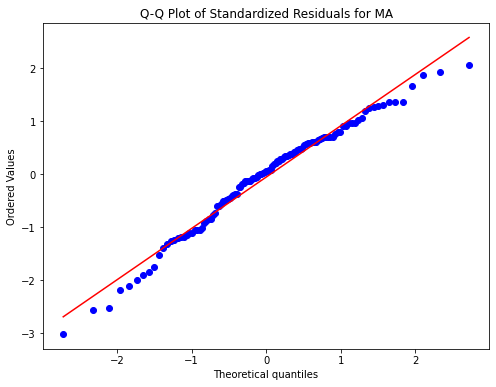

Results for NVDA
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                   Log Return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                77.3185
Distribution:      Standardized Student's t   AIC:                          -144.637
Method:                  Maximum Likelihood   BIC:                          -130.741
                                              No. Observations:                  119
Date:                      Sat, Jun 01 2024   Df Residuals:                      118
Time:                              01:25:39   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------

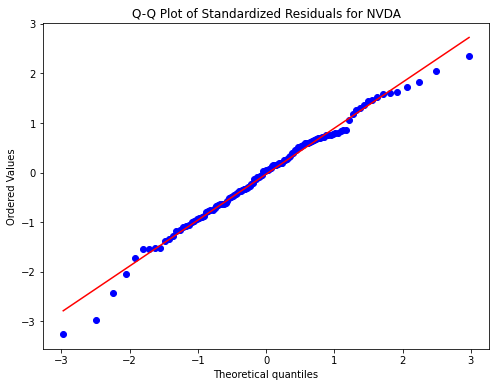

Results for AMD
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                   Log Return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                50.7392
Distribution:      Standardized Student's t   AIC:                          -91.4784
Method:                  Maximum Likelihood   BIC:                          -77.5828
                                              No. Observations:                  119
Date:                      Sat, Jun 01 2024   Df Residuals:                      118
Time:                              01:25:39   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
-----------------------------------------------------------------

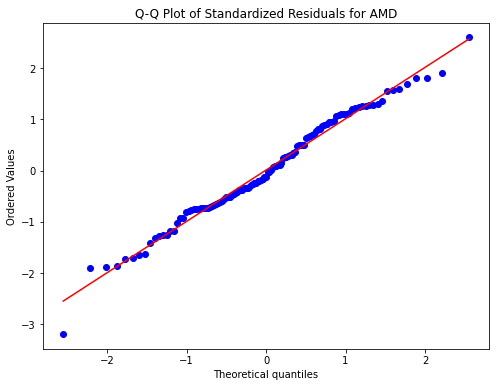

Results for MSFT
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                   Log Return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                166.921
Distribution:      Standardized Student's t   AIC:                          -323.842
Method:                  Maximum Likelihood   BIC:                          -309.946
                                              No. Observations:                  119
Date:                      Sat, Jun 01 2024   Df Residuals:                      118
Time:                              01:25:39   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------

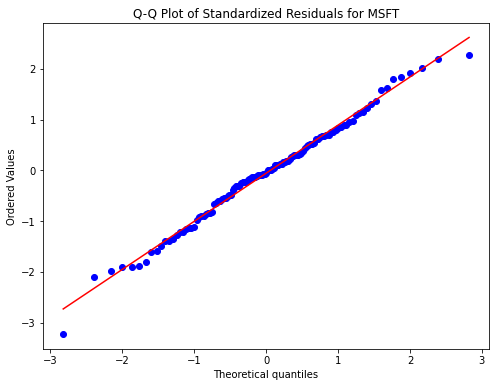

Results for GOOGL
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                   Log Return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                155.567
Distribution:      Standardized Student's t   AIC:                          -301.135
Method:                  Maximum Likelihood   BIC:                          -287.239
                                              No. Observations:                  119
Date:                      Sat, Jun 01 2024   Df Residuals:                      118
Time:                              01:25:39   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
---------------------------------------------------------------

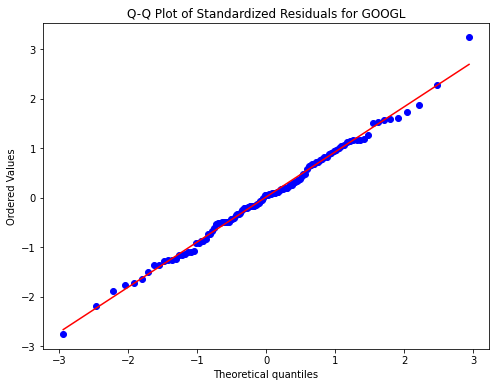

Results for AMZN
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                   Log Return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                124.206
Distribution:      Standardized Student's t   AIC:                          -238.411
Method:                  Maximum Likelihood   BIC:                          -224.515
                                              No. Observations:                  119
Date:                      Sat, Jun 01 2024   Df Residuals:                      118
Time:                              01:25:39   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------

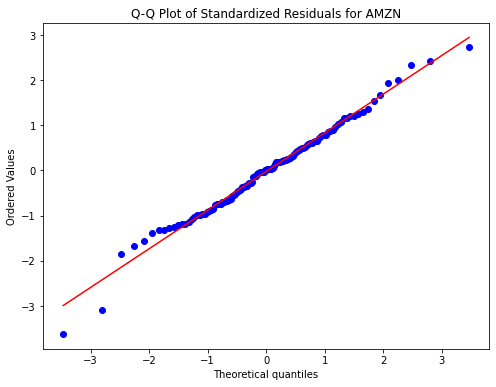

Results for AAPL
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                   Log Return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                135.365
Distribution:      Standardized Student's t   AIC:                          -260.730
Method:                  Maximum Likelihood   BIC:                          -246.834
                                              No. Observations:                  119
Date:                      Sat, Jun 01 2024   Df Residuals:                      118
Time:                              01:25:39   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------

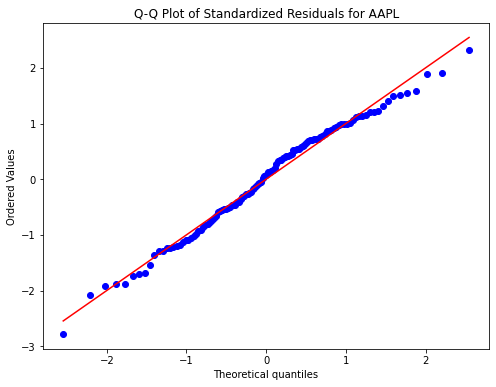

Results for REGN
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                   Log Return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                120.284
Distribution:      Standardized Student's t   AIC:                          -230.567
Method:                  Maximum Likelihood   BIC:                          -216.672
                                              No. Observations:                  119
Date:                      Sat, Jun 01 2024   Df Residuals:                      118
Time:                              01:25:39   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
--------------------------------------------------------------

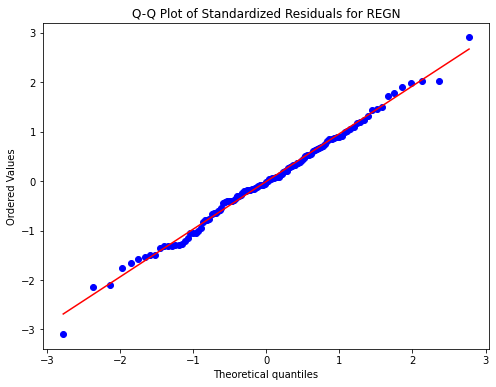

Results for GILD
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                   Log Return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                149.952
Distribution:      Standardized Student's t   AIC:                          -289.905
Method:                  Maximum Likelihood   BIC:                          -276.009
                                              No. Observations:                  119
Date:                      Sat, Jun 01 2024   Df Residuals:                      118
Time:                              01:25:39   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------

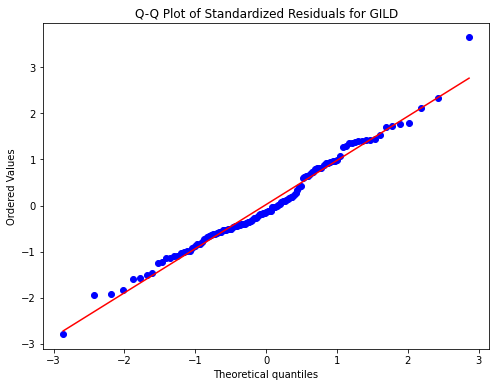

Results for AMGN
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                   Log Return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                150.424
Distribution:      Standardized Student's t   AIC:                          -290.848
Method:                  Maximum Likelihood   BIC:                          -276.952
                                              No. Observations:                  119
Date:                      Sat, Jun 01 2024   Df Residuals:                      118
Time:                              01:25:39   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
--------------------------------------------------------------

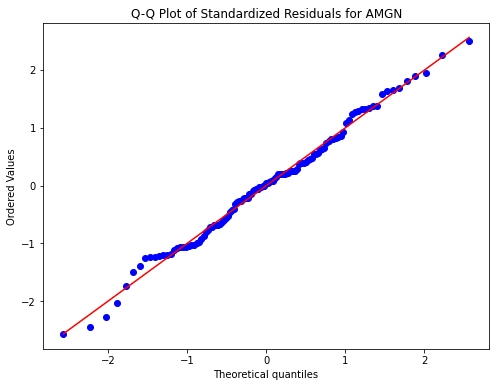

Results for VRTX
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                   Log Return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                125.835
Distribution:      Standardized Student's t   AIC:                          -241.670
Method:                  Maximum Likelihood   BIC:                          -227.775
                                              No. Observations:                  119
Date:                      Sat, Jun 01 2024   Df Residuals:                      118
Time:                              01:25:40   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------

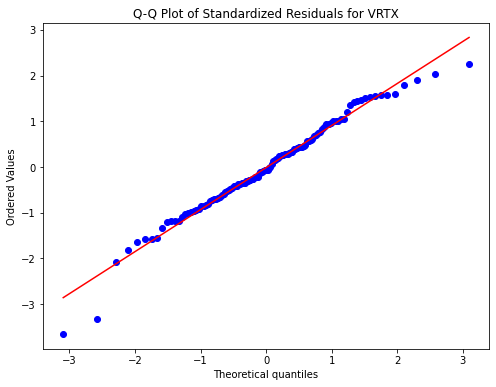

Results for BIIB
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                   Log Return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                121.694
Distribution:      Standardized Student's t   AIC:                          -233.389
Method:                  Maximum Likelihood   BIC:                          -219.493
                                              No. Observations:                  119
Date:                      Sat, Jun 01 2024   Df Residuals:                      118
Time:                              01:25:40   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------

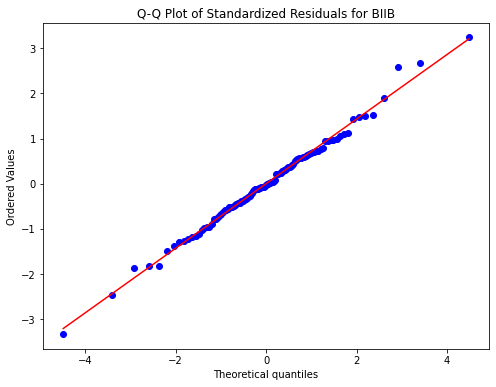

Results for ILMN
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                   Log Return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                92.1414
Distribution:      Standardized Student's t   AIC:                          -174.283
Method:                  Maximum Likelihood   BIC:                          -160.387
                                              No. Observations:                  119
Date:                      Sat, Jun 01 2024   Df Residuals:                      118
Time:                              01:25:40   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
--------------------------------------------------------------

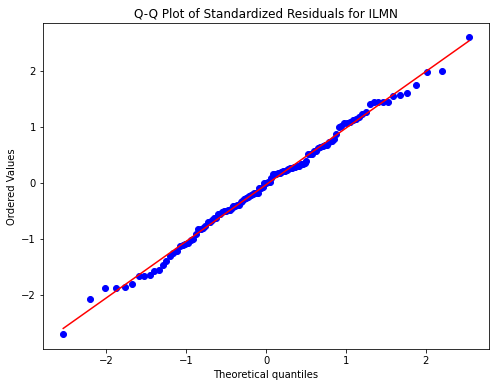

Results for PG
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                   Log Return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                200.256
Distribution:      Standardized Student's t   AIC:                          -390.513
Method:                  Maximum Likelihood   BIC:                          -376.617
                                              No. Observations:                  119
Date:                      Sat, Jun 01 2024   Df Residuals:                      118
Time:                              01:25:40   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
----------------------------------------------------------------

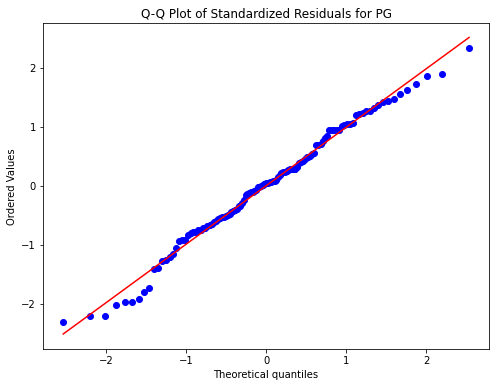

Results for KO
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                   Log Return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                204.323
Distribution:      Standardized Student's t   AIC:                          -398.645
Method:                  Maximum Likelihood   BIC:                          -384.750
                                              No. Observations:                  119
Date:                      Sat, Jun 01 2024   Df Residuals:                      118
Time:                              01:25:40   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
------------------------------------------------------------------

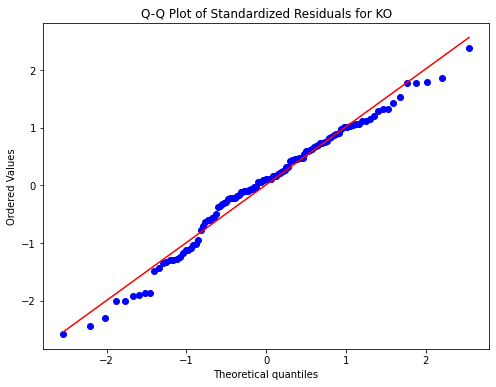

Results for PEP
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                   Log Return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                209.441
Distribution:      Standardized Student's t   AIC:                          -408.882
Method:                  Maximum Likelihood   BIC:                          -394.986
                                              No. Observations:                  119
Date:                      Sat, Jun 01 2024   Df Residuals:                      118
Time:                              01:25:40   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
-----------------------------------------------------------------

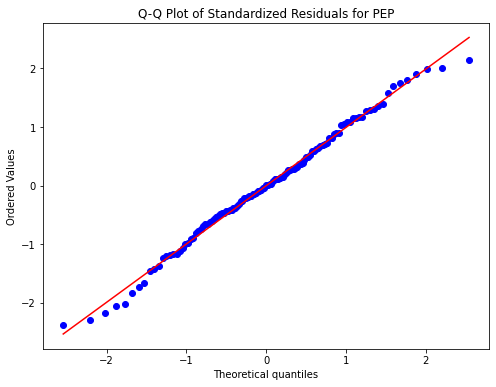

Results for WMT
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                   Log Return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                184.209
Distribution:      Standardized Student's t   AIC:                          -358.418
Method:                  Maximum Likelihood   BIC:                          -344.522
                                              No. Observations:                  119
Date:                      Sat, Jun 01 2024   Df Residuals:                      118
Time:                              01:25:40   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
-----------------------------------------------------------------

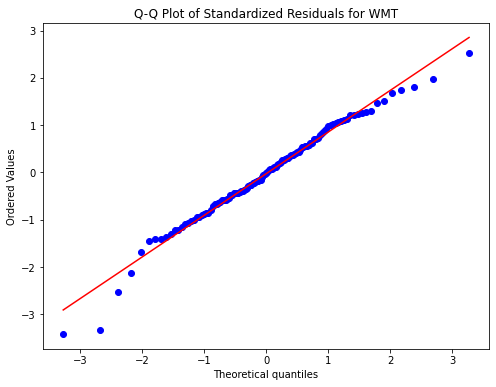

Results for CL
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                   Log Return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                201.211
Distribution:      Standardized Student's t   AIC:                          -392.422
Method:                  Maximum Likelihood   BIC:                          -378.526
                                              No. Observations:                  119
Date:                      Sat, Jun 01 2024   Df Residuals:                      118
Time:                              01:25:40   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
----------------------------------------------------------------

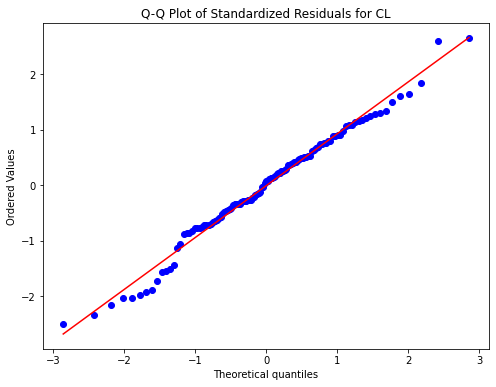

Results for COST
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                   Log Return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                174.466
Distribution:      Standardized Student's t   AIC:                          -338.933
Method:                  Maximum Likelihood   BIC:                          -325.037
                                              No. Observations:                  119
Date:                      Sat, Jun 01 2024   Df Residuals:                      118
Time:                              01:25:40   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------

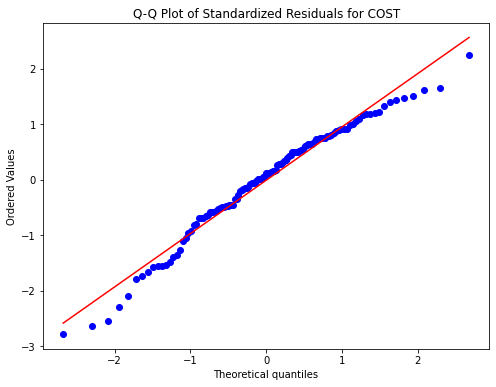

Results for BHP
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                   Log Return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                117.052
Distribution:      Standardized Student's t   AIC:                          -224.105
Method:                  Maximum Likelihood   BIC:                          -210.209
                                              No. Observations:                  119
Date:                      Sat, Jun 01 2024   Df Residuals:                      118
Time:                              01:25:40   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
---------------------------------------------------------------

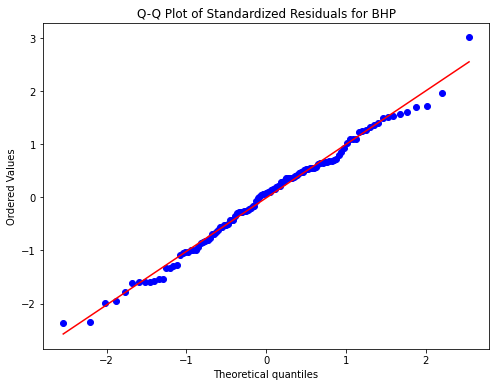

Results for RIO
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                   Log Return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                130.665
Distribution:      Standardized Student's t   AIC:                          -251.329
Method:                  Maximum Likelihood   BIC:                          -237.434
                                              No. Observations:                  119
Date:                      Sat, Jun 01 2024   Df Residuals:                      118
Time:                              01:25:40   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
---------------------------------------------------------------

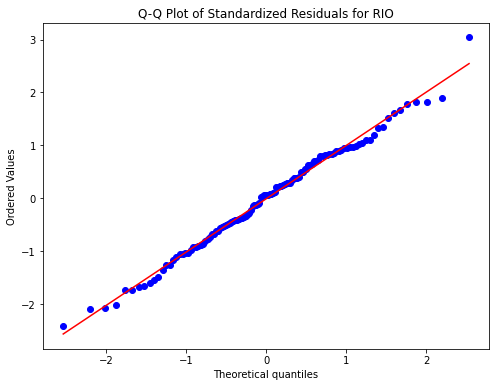

Results for VALE
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                   Log Return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                78.2386
Distribution:      Standardized Student's t   AIC:                          -146.477
Method:                  Maximum Likelihood   BIC:                          -132.582
                                              No. Observations:                  119
Date:                      Sat, Jun 01 2024   Df Residuals:                      118
Time:                              01:25:40   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
--------------------------------------------------------------

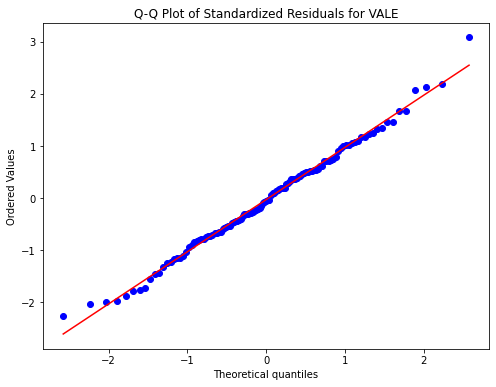

Results for FCX
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                   Log Return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                48.5176
Distribution:      Standardized Student's t   AIC:                          -87.0353
Method:                  Maximum Likelihood   BIC:                          -73.1397
                                              No. Observations:                  119
Date:                      Sat, Jun 01 2024   Df Residuals:                      118
Time:                              01:25:40   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
---------------------------------------------------------------

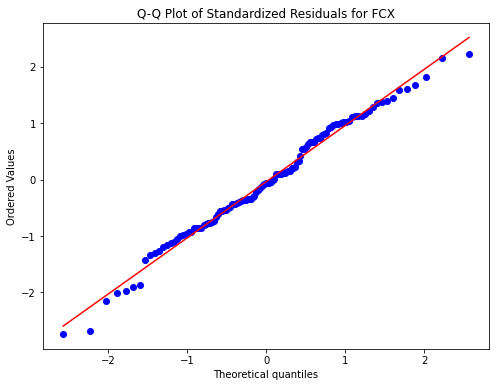

Results for GOLD
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                   Log Return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                86.2727
Distribution:      Standardized Student's t   AIC:                          -162.545
Method:                  Maximum Likelihood   BIC:                          -148.650
                                              No. Observations:                  119
Date:                      Sat, Jun 01 2024   Df Residuals:                      118
Time:                              01:25:41   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
--------------------------------------------------------------

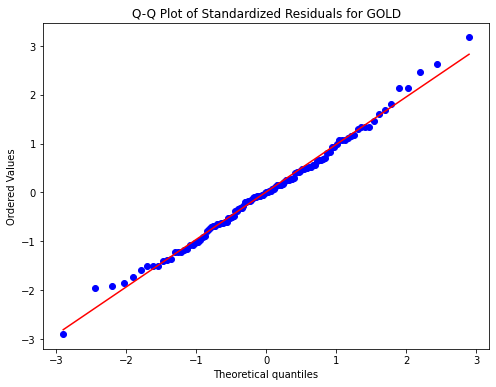

Results for NEM
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                   Log Return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                100.157
Distribution:      Standardized Student's t   AIC:                          -190.314
Method:                  Maximum Likelihood   BIC:                          -176.419
                                              No. Observations:                  119
Date:                      Sat, Jun 01 2024   Df Residuals:                      118
Time:                              01:25:41   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
---------------------------------------------------------------

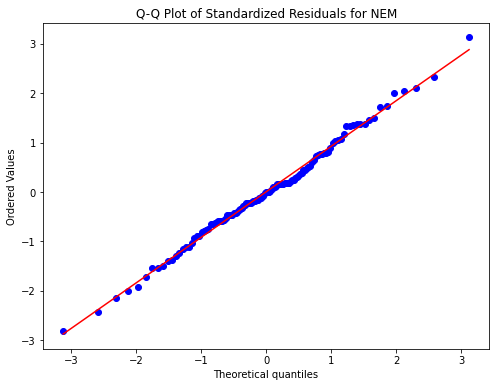

Results for ISRG
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                   Log Return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                136.395
Distribution:      Standardized Student's t   AIC:                          -262.790
Method:                  Maximum Likelihood   BIC:                          -248.894
                                              No. Observations:                  119
Date:                      Sat, Jun 01 2024   Df Residuals:                      118
Time:                              01:25:41   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------

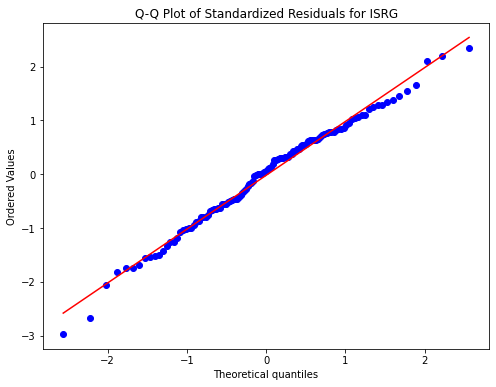

Results for SYK
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                   Log Return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                173.178
Distribution:      Standardized Student's t   AIC:                          -336.355
Method:                  Maximum Likelihood   BIC:                          -322.460
                                              No. Observations:                  119
Date:                      Sat, Jun 01 2024   Df Residuals:                      118
Time:                              01:25:41   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
-----------------------------------------------------------------

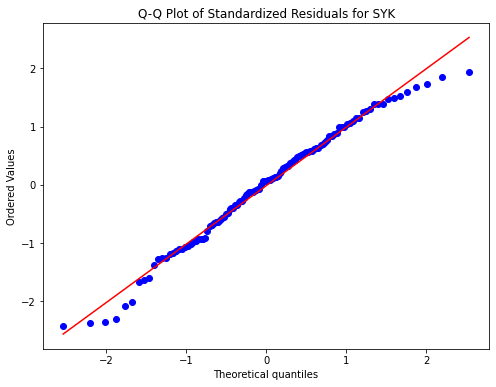

Results for TMO
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                   Log Return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                167.674
Distribution:      Standardized Student's t   AIC:                          -325.348
Method:                  Maximum Likelihood   BIC:                          -311.453
                                              No. Observations:                  119
Date:                      Sat, Jun 01 2024   Df Residuals:                      118
Time:                              01:25:41   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
-----------------------------------------------------------------

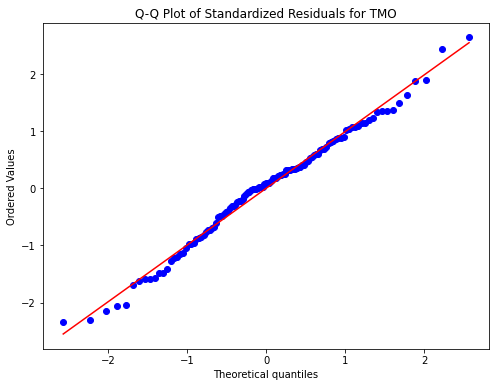

Results for MDT
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                   Log Return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                171.884
Distribution:      Standardized Student's t   AIC:                          -333.769
Method:                  Maximum Likelihood   BIC:                          -319.873
                                              No. Observations:                  119
Date:                      Sat, Jun 01 2024   Df Residuals:                      118
Time:                              01:25:41   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
---------------------------------------------------------------

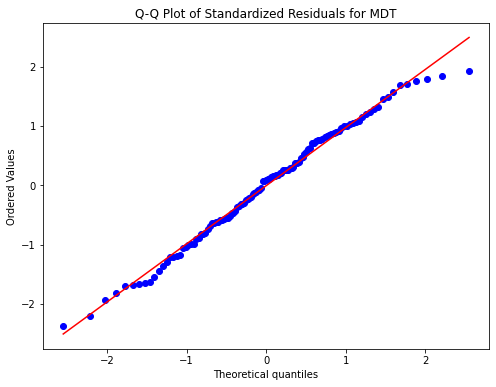

Results for DHR
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                   Log Return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                173.817
Distribution:      Standardized Student's t   AIC:                          -337.634
Method:                  Maximum Likelihood   BIC:                          -323.738
                                              No. Observations:                  119
Date:                      Sat, Jun 01 2024   Df Residuals:                      118
Time:                              01:25:41   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
-----------------------------------------------------------------

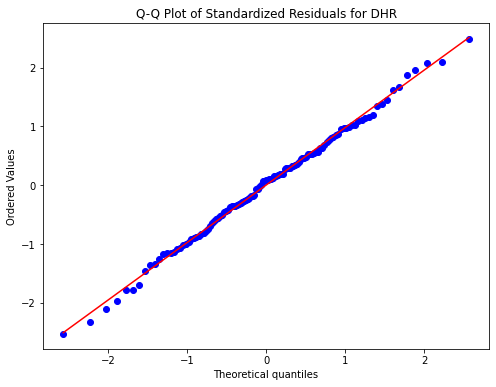

Results for ABT
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                   Log Return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                171.650
Distribution:      Standardized Student's t   AIC:                          -333.301
Method:                  Maximum Likelihood   BIC:                          -319.405
                                              No. Observations:                  119
Date:                      Sat, Jun 01 2024   Df Residuals:                      118
Time:                              01:25:41   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
---------------------------------------------------------------

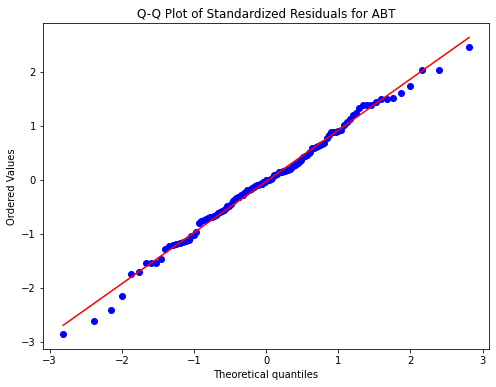

Results for PBR
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                   Log Return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                53.6947
Distribution:      Standardized Student's t   AIC:                          -97.3894
Method:                  Maximum Likelihood   BIC:                          -83.4938
                                              No. Observations:                  119
Date:                      Sat, Jun 01 2024   Df Residuals:                      118
Time:                              01:25:41   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
---------------------------------------------------------------

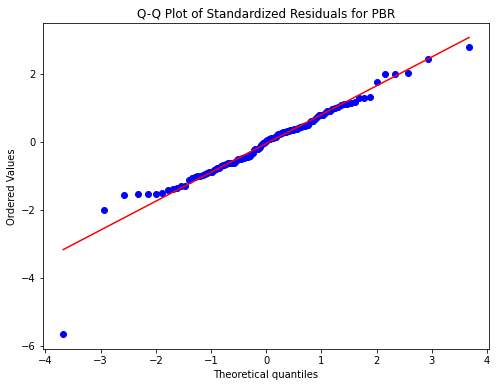

Results for TCEHY
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                   Log Return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                117.459
Distribution:      Standardized Student's t   AIC:                          -224.917
Method:                  Maximum Likelihood   BIC:                          -211.022
                                              No. Observations:                  119
Date:                      Sat, Jun 01 2024   Df Residuals:                      118
Time:                              01:25:41   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-------------------------------------------------------------

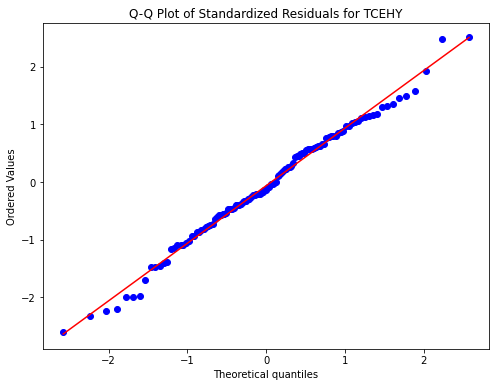

Results for MELI
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                   Log Return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                79.9254
Distribution:      Standardized Student's t   AIC:                          -149.851
Method:                  Maximum Likelihood   BIC:                          -135.955
                                              No. Observations:                  119
Date:                      Sat, Jun 01 2024   Df Residuals:                      118
Time:                              01:25:41   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------

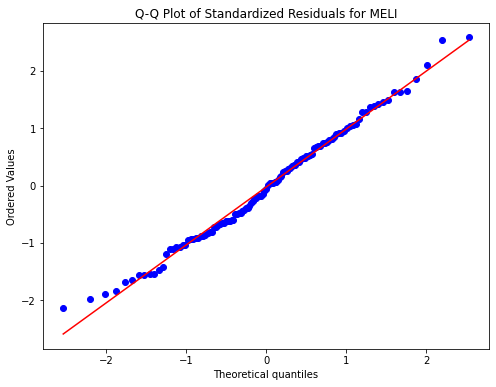

Results for INFY
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                   Log Return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                145.498
Distribution:      Standardized Student's t   AIC:                          -280.995
Method:                  Maximum Likelihood   BIC:                          -267.099
                                              No. Observations:                  119
Date:                      Sat, Jun 01 2024   Df Residuals:                      118
Time:                              01:25:41   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
--------------------------------------------------------------

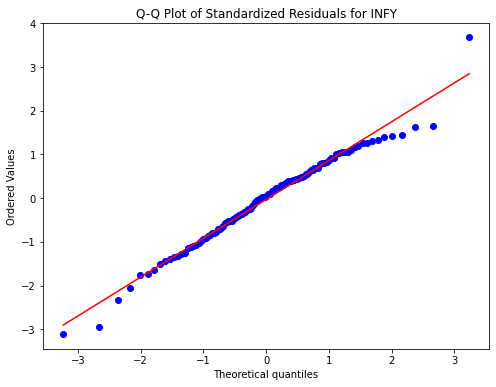

Results for BIDU
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                   Log Return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                93.8281
Distribution:      Standardized Student's t   AIC:                          -177.656
Method:                  Maximum Likelihood   BIC:                          -163.761
                                              No. Observations:                  119
Date:                      Sat, Jun 01 2024   Df Residuals:                      118
Time:                              01:25:41   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------

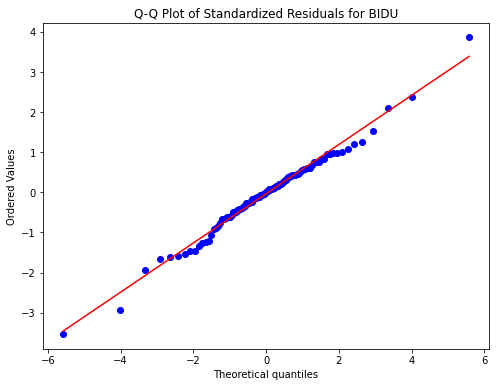

Results for NTES
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                   Log Return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                100.552
Distribution:      Standardized Student's t   AIC:                          -191.103
Method:                  Maximum Likelihood   BIC:                          -177.208
                                              No. Observations:                  119
Date:                      Sat, Jun 01 2024   Df Residuals:                      118
Time:                              01:25:42   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
--------------------------------------------------------------

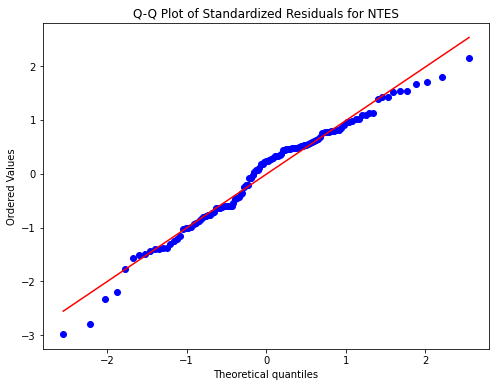

Results for AMT
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                   Log Return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                166.396
Distribution:      Standardized Student's t   AIC:                          -322.792
Method:                  Maximum Likelihood   BIC:                          -308.897
                                              No. Observations:                  119
Date:                      Sat, Jun 01 2024   Df Residuals:                      118
Time:                              01:25:42   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
---------------------------------------------------------------

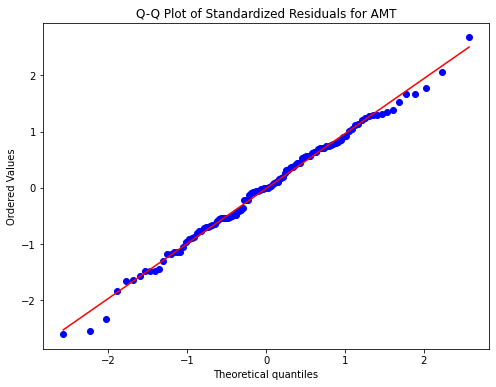

Results for PLD
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                   Log Return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                155.046
Distribution:      Standardized Student's t   AIC:                          -300.091
Method:                  Maximum Likelihood   BIC:                          -286.195
                                              No. Observations:                  119
Date:                      Sat, Jun 01 2024   Df Residuals:                      118
Time:                              01:25:42   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
-----------------------------------------------------------------

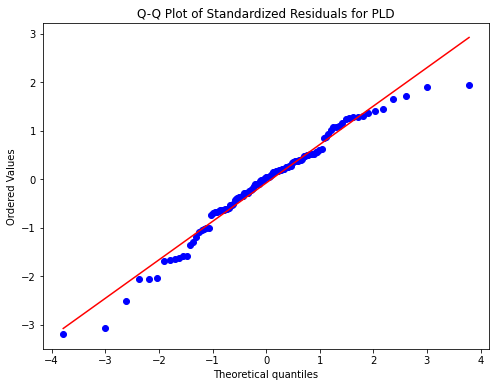

Results for CCI
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                   Log Return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                171.184
Distribution:      Standardized Student's t   AIC:                          -332.369
Method:                  Maximum Likelihood   BIC:                          -318.473
                                              No. Observations:                  119
Date:                      Sat, Jun 01 2024   Df Residuals:                      118
Time:                              01:25:42   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
---------------------------------------------------------------

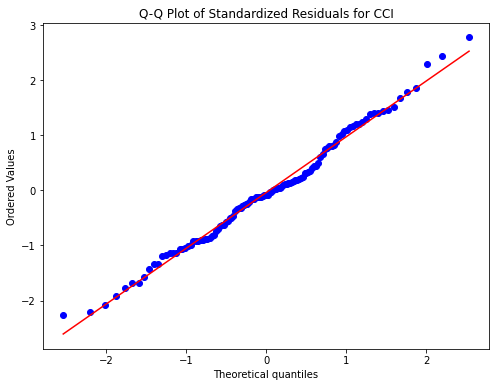

Results for PSA
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                   Log Return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                171.961
Distribution:      Standardized Student's t   AIC:                          -333.923
Method:                  Maximum Likelihood   BIC:                          -320.027
                                              No. Observations:                  119
Date:                      Sat, Jun 01 2024   Df Residuals:                      118
Time:                              01:25:42   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
---------------------------------------------------------------

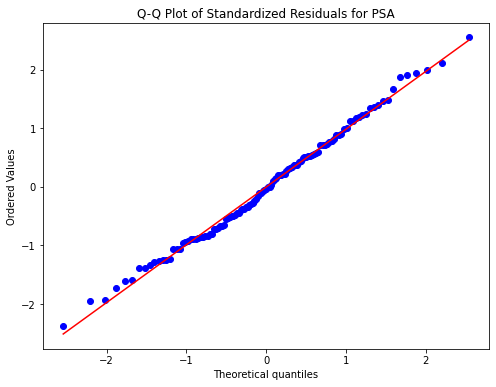

Results for EQIX
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                   Log Return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                166.035
Distribution:      Standardized Student's t   AIC:                          -322.070
Method:                  Maximum Likelihood   BIC:                          -308.174
                                              No. Observations:                  119
Date:                      Sat, Jun 01 2024   Df Residuals:                      118
Time:                              01:25:42   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------

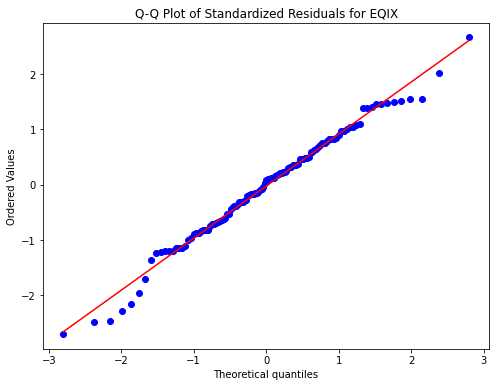

Results for SPG
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                   Log Return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                137.709
Distribution:      Standardized Student's t   AIC:                          -265.419
Method:                  Maximum Likelihood   BIC:                          -251.523
                                              No. Observations:                  119
Date:                      Sat, Jun 01 2024   Df Residuals:                      118
Time:                              01:25:42   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
---------------------------------------------------------------

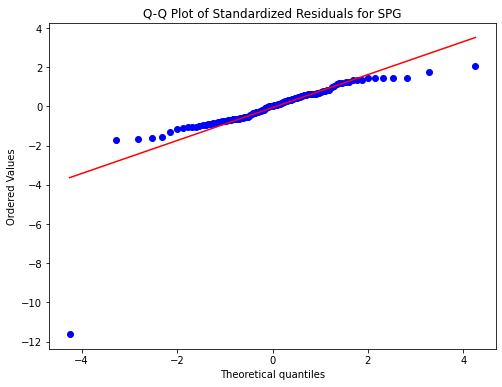

Results for HON
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                   Log Return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                180.819
Distribution:      Standardized Student's t   AIC:                          -351.638
Method:                  Maximum Likelihood   BIC:                          -337.743
                                              No. Observations:                  119
Date:                      Sat, Jun 01 2024   Df Residuals:                      118
Time:                              01:25:42   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
-----------------------------------------------------------------

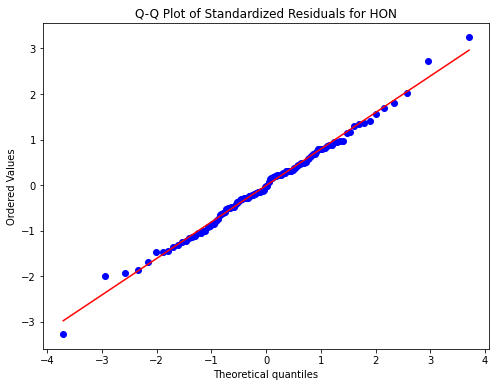

Results for UNP
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                   Log Return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                155.645
Distribution:      Standardized Student's t   AIC:                          -301.291
Method:                  Maximum Likelihood   BIC:                          -287.395
                                              No. Observations:                  119
Date:                      Sat, Jun 01 2024   Df Residuals:                      118
Time:                              01:25:42   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
---------------------------------------------------------------

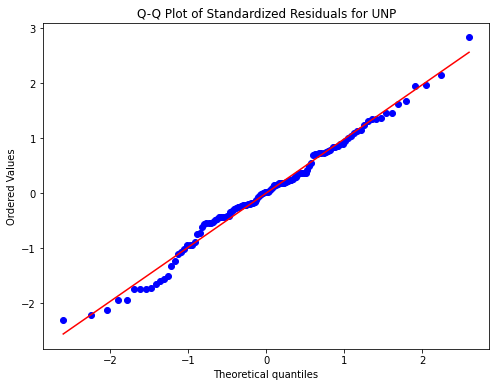

Results for CAT
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                   Log Return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                126.598
Distribution:      Standardized Student's t   AIC:                          -243.196
Method:                  Maximum Likelihood   BIC:                          -229.301
                                              No. Observations:                  119
Date:                      Sat, Jun 01 2024   Df Residuals:                      118
Time:                              01:25:42   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
---------------------------------------------------------------

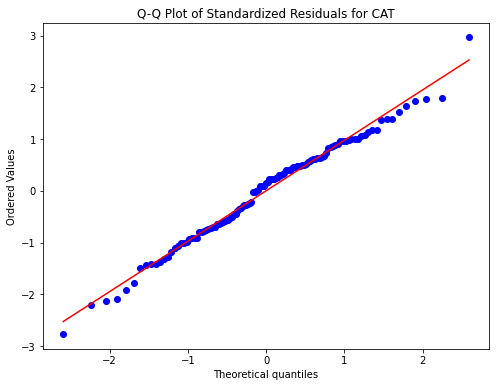

Results for DE
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                   Log Return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                143.450
Distribution:      Standardized Student's t   AIC:                          -276.900
Method:                  Maximum Likelihood   BIC:                          -263.005
                                              No. Observations:                  119
Date:                      Sat, Jun 01 2024   Df Residuals:                      118
Time:                              01:25:42   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
----------------------------------------------------------------

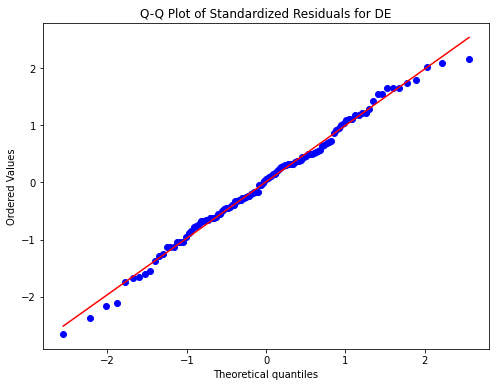

Results for MMM
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                   Log Return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                165.789
Distribution:      Standardized Student's t   AIC:                          -321.579
Method:                  Maximum Likelihood   BIC:                          -307.683
                                              No. Observations:                  119
Date:                      Sat, Jun 01 2024   Df Residuals:                      118
Time:                              01:25:42   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
---------------------------------------------------------------

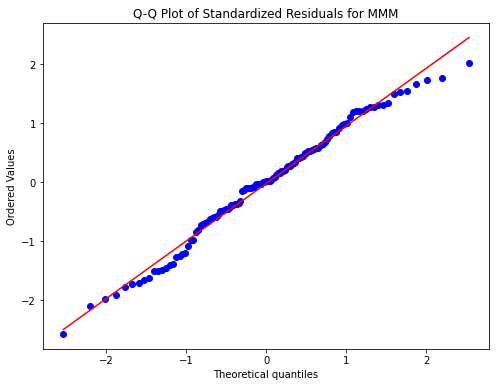

Results for LMT
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                   Log Return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                173.535
Distribution:      Standardized Student's t   AIC:                          -337.071
Method:                  Maximum Likelihood   BIC:                          -323.175
                                              No. Observations:                  119
Date:                      Sat, Jun 01 2024   Df Residuals:                      118
Time:                              01:25:43   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
-----------------------------------------------------------------

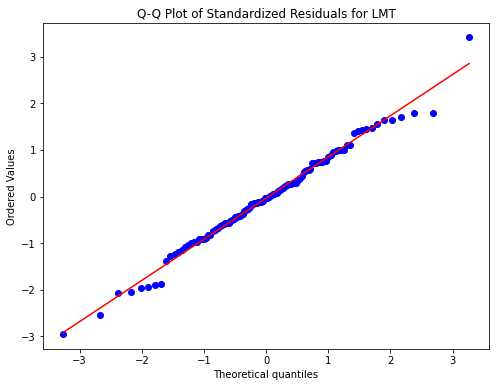

In [63]:
from arch import arch_model
import scipy.stats as stats

warnings.filterwarnings("ignore")

# Loop through each dataset and fit a GARCH model with t-distributed errors
for name, returns in returns_data.items():
    # Fit the GARCH model with t-distributed errors
    garch_t = arch_model(returns, vol='Garch', p=1, q=1, dist='StudentsT')
    res = garch_t.fit(update_freq=5, disp='off')

    # Print the summary of the fit
    print(f"Results for {name}")
    print(res.summary())

    # Obtain the standardized residuals
    std_resid = res.resid / res.conditional_volatility

    # Degrees of freedom parameter estimated by the model
    nu = res.params['nu']

    # Generate a Q-Q plot of the standardized residuals
    plt.figure(figsize=(8, 6))
    stats.probplot(std_resid, dist="t", sparams=(nu,), plot=plt)
    plt.title(f'Q-Q Plot of Standardized Residuals for {name}')
    plt.show()

<span style="color: green; font-weight: bold; font-size: 23px;">Risk Management</span>

<span style="color:red; font-weight:bold; font-size:22px">VaR and CVaR</span>

VaR and CVaR Summary Statistics:
            VaR      CVaR
NVDA  -0.208219 -0.286673
AMD   -0.230730 -0.323803
MSFT  -0.078335 -0.110069
GOOGL -0.101495 -0.140877
AMZN  -0.118051 -0.180207
AAPL  -0.124089 -0.148528
ISRG  -0.108563 -0.163063
SYK   -0.102683 -0.124484
TMO   -0.095187 -0.121370
MDT   -0.101993 -0.115645
DHR   -0.079472 -0.125309
ABT   -0.083244 -0.123003
PG    -0.082204 -0.090937
KO    -0.075234 -0.116924
PEP   -0.072939 -0.086265
WMT   -0.068530 -0.128242
CL    -0.086359 -0.096805
COST  -0.100308 -0.132473
JPM   -0.125476 -0.162038
BLK   -0.113215 -0.161326
V     -0.087070 -0.108239
GS    -0.117388 -0.169313
MS    -0.130398 -0.187093
MA    -0.117665 -0.143652
HON   -0.088443 -0.125515
UNP   -0.107594 -0.130647
CAT   -0.126849 -0.180519
DE    -0.117663 -0.148619
MMM   -0.121576 -0.142100
LMT   -0.090461 -0.126151


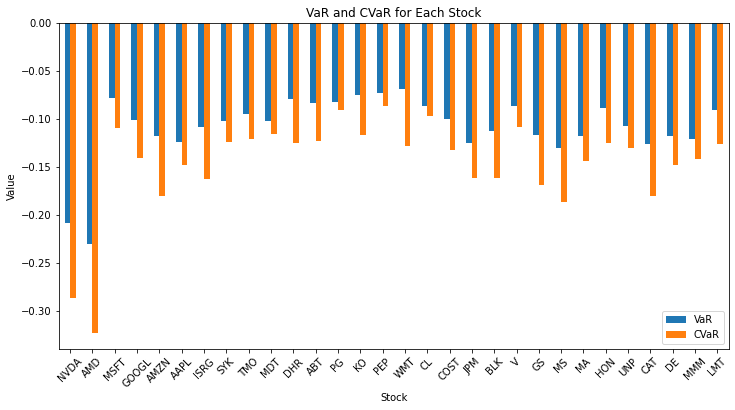

In [12]:
# Define a function to calculate VaR and CVaR
def calculate_var_cvar(returns, confidence_level=0.95):
    # Ensure returns are in a numpy array
    returns = np.sort(returns)
    
    # Calculate the index at the confidence level
    var_index = int((1 - confidence_level) * len(returns))
    
    # Calculate VaR
    var = returns[var_index]
    
    # Calculate CVaR as the average of losses beyond the VaR
    cvar = returns[:var_index].mean()
    
    return var, cvar

# Initialize dictionaries to store VaR and CVaR for each stock
var_cvar_results = {}

# Calculate VaR and CVaR for each stock
for name, returns in returns_data.items():
    var, cvar = calculate_var_cvar(returns, confidence_level=0.95)
    var_cvar_results[name] = {'VaR': var, 'CVaR': cvar}

# Convert results to DataFrame for better visualization
var_cvar_df = pd.DataFrame(var_cvar_results).T

# Print summary statistics
print("VaR and CVaR Summary Statistics:")
print(var_cvar_df)

# Plot VaR and CVaR for each stock
var_cvar_df.plot(kind='bar', figsize=(12, 6))
plt.title('VaR and CVaR for Each Stock')
plt.ylabel('Value')
plt.xlabel('Stock')
plt.xticks(rotation=45)
plt.show()

<span style="color:blue; font-weight:bold; font-size:30px"> Stock Selection</span>

<span style="color:red; font-weight:bold; font-size:22px">Comparing Composite Financial and Risk Scores</span>

In [13]:
from scipy.stats import skew, kurtosis

# Define a function to calculate annual return, volatility, and Sharpe Ratio for individual stocks
def calculate_individual_metrics(log_returns):
    annual_return = log_returns.mean() * 12  # Annualize the average monthly return
    annual_volatility = log_returns.std() * np.sqrt(12)  # Annualize the monthly volatility
    sharpe_ratio = annual_return / annual_volatility
    stock_skewness = skew(log_returns)
    stock_kurtosis = kurtosis(log_returns)
    return annual_return, annual_volatility, sharpe_ratio, stock_skewness, stock_kurtosis

# Initialize DataFrame to store metrics for all stocks
metrics_df = pd.DataFrame(columns=['Date', 'Stock', 'Annual Return', 'Volatility', 'Sharpe Ratio', 'Skewness', 'Kurtosis', 'CAPM Return', 'Significant ACF Lags', 'Significant PACF Lags', 'VaR', 'CVaR'])

# Load the returns data
data_files = {ticker: f'stock_data/{industry.replace(" ", "_")}/{ticker}_monthly_log_returns.csv' for industry, tickers in top5_industries.items() for ticker in tickers}
returns_data = {name: pd.read_csv(path, index_col=0, parse_dates=True)['Log Return'].dropna().squeeze() for name, path in data_files.items()}

# Load market returns and filter by date range
market_returns = pd.read_csv('stock_data/SPY_data.csv', index_col=0, parse_dates=True)['SPY Return']
market_returns = market_returns[(market_returns.index >= '2014-05-01') & (market_returns.index <= '2024-04-30')]

# Loop through each stock's returns and calculate metrics
for name, returns in returns_data.items():
    # Calculate CAPM Return
    try:
        beta = calculate_beta(returns, market_returns)
        capm_return = calculate_capm_return(beta, risk_free_rate, market_returns.mean())
    except ValueError as e:
        capm_return = np.nan
        print(f"Error calculating CAPM for {name}: {e}")
    
    # Calculate VaR and CVaR
    var, cvar = calculate_var_cvar(returns)

    # Calculate Annual Return, Volatility, Sharpe Ratio, Skewness, and Kurtosis
    annual_return, annual_volatility, sharpe_ratio, stock_skewness, stock_kurtosis = calculate_individual_metrics(returns)

    # Check for significant autocorrelations
    max_lags = min(20, len(returns) // 2 - 1)
    acf_values = acf(returns, nlags=max_lags)
    pacf_values = pacf(returns, nlags=max_lags)
    significant_acf_lags = np.sum(np.abs(acf_values[1:]) > 1.96 / np.sqrt(len(returns)))
    significant_pacf_lags = np.sum(np.abs(pacf_values[1:]) > 1.96 / np.sqrt(len(returns)))

    # Create a DataFrame for the current stock's metrics
    stock_metrics_df = pd.DataFrame({
        'Date': [returns.index[-1]],
        'Stock': [name],
        'Annual Return': [annual_return],
        'Volatility': [annual_volatility],
        'Sharpe Ratio': [sharpe_ratio],
        'Skewness': [stock_skewness],
        'Kurtosis': [stock_kurtosis],
        'CAPM Return': [capm_return],
        'Significant ACF Lags': [significant_acf_lags],
        'Significant PACF Lags': [significant_pacf_lags],
        'VaR': [var],
        'CVaR': [cvar]
    })

    # Save the metrics DataFrame to the corresponding stock's file
    file_path = f'stock_data/{name}_metrics.csv'
    stock_metrics_df.to_csv(file_path, index=False)

    # Append the current stock's metrics to the overall metrics DataFrame
    metrics_df = pd.concat([metrics_df, stock_metrics_df], ignore_index=True)

    print(f"Metrics for {name} saved to {file_path}")

# Save the overall metrics DataFrame
metrics_df.to_csv('stock_data/all_stock_metrics.csv', index=False)
print("All stock metrics saved to 'stock_data/all_stock_metrics.csv'")
# Print all stocks based on composite score with industry information

Metrics for NVDA saved to stock_data/NVDA_metrics.csv
Metrics for AMD saved to stock_data/AMD_metrics.csv
Metrics for MSFT saved to stock_data/MSFT_metrics.csv
Metrics for GOOGL saved to stock_data/GOOGL_metrics.csv
Metrics for AMZN saved to stock_data/AMZN_metrics.csv
Metrics for AAPL saved to stock_data/AAPL_metrics.csv
Metrics for ISRG saved to stock_data/ISRG_metrics.csv
Metrics for SYK saved to stock_data/SYK_metrics.csv
Metrics for TMO saved to stock_data/TMO_metrics.csv
Metrics for MDT saved to stock_data/MDT_metrics.csv
Metrics for DHR saved to stock_data/DHR_metrics.csv
Metrics for ABT saved to stock_data/ABT_metrics.csv
Metrics for PG saved to stock_data/PG_metrics.csv
Metrics for KO saved to stock_data/KO_metrics.csv
Metrics for PEP saved to stock_data/PEP_metrics.csv
Metrics for WMT saved to stock_data/WMT_metrics.csv
Metrics for CL saved to stock_data/CL_metrics.csv
Metrics for COST saved to stock_data/COST_metrics.csv
Metrics for JPM saved to stock_data/JPM_metrics.csv
Me

In [14]:
# Load the overall metrics DataFrame
metrics_df = pd.read_csv('stock_data/all_stock_metrics.csv', index_col=0, parse_dates=True)

# Add industry information to metrics_df
metrics_df['Industry'] = metrics_df['Stock'].apply(
    lambda stock: next((industry for industry, stocks in top5_industries.items() if stock in stocks), 'Unknown')
)

# Create directories for industries if they do not exist
for industry in top5_industries.keys():
    industry_dir = f'stock_data/{industry.replace(" ", "_")}'
    if not os.path.exists(industry_dir):
        os.makedirs(industry_dir)

# Define adjusted weights for each metric
weights = {
    'Annual Return': 0.3,
    'Volatility': -0.1,  # Negative weight because we prefer lower volatility
    'Sharpe Ratio': 0.2,  # Include Sharpe Ratio with a positive weight
    'Skewness': -0.05,  # Prefer lower skewness (closer to normal distribution)
    'Kurtosis': -0.05,  # Prefer lower kurtosis (closer to normal distribution)
    'CAPM Return': 0.2,
    'Significant ACF Lags': -0.05,  # Negative weight because we prefer fewer significant lags
    'Significant PACF Lags': -0.05,  # Negative weight because we prefer fewer significant lags
    'VaR': -0.1,  # Negative weight because we prefer lower VaR
    'CVaR': -0.1  # Negative weight because we prefer lower CVaR
}

# Normalize the metrics for scoring
for metric in weights.keys():
    metrics_df[f'{metric} Score'] = (metrics_df[metric] - metrics_df[metric].mean()) / metrics_df[metric].std()

# Calculate the composite score
metrics_df['Composite Score'] = sum(metrics_df[f'{metric} Score'] * weight for metric, weight in weights.items())

# Sort stocks based on composite score
sorted_metrics_df = metrics_df.sort_values(by='Composite Score', ascending=False)

# Save metrics to individual stock files in their respective industry directories
for industry, tickers in top5_industries.items():
    industry_dir = f'stock_data/{industry.replace(" ", "_")}'
    for ticker in tickers:
        stock_metrics_df = metrics_df[metrics_df['Stock'] == ticker]
        file_path = f'{industry_dir}/{ticker}_metrics.csv'
        stock_metrics_df.to_csv(file_path, index=False)

# Print all stocks based on composite score with industry information
print("All stocks based on composite score:")
print(sorted_metrics_df[['Stock', 'Industry', 'Composite Score']])

All stocks based on composite score:
            Stock                                Industry  Composite Score
Date                                                                      
2024-04-30   NVDA  Artificial Intelligence and Technology         1.945385
2024-04-30    AMD  Artificial Intelligence and Technology         1.130832
2024-04-30   COST                        Consumer Staples         0.759211
2024-04-30   AMZN  Artificial Intelligence and Technology         0.660971
2024-04-30   MSFT  Artificial Intelligence and Technology         0.651237
2024-04-30   AAPL  Artificial Intelligence and Technology         0.519186
2024-04-30   ISRG                       Health Technology         0.472593
2024-04-30    TMO                       Health Technology         0.217022
2024-04-30    DHR                       Health Technology         0.199502
2024-04-30     MA                                 Finance         0.124236
2024-04-30    JPM                                 Finance      

<span style="color: dark green; font-weight: bold; font-size: 15px;">From the resulting analysis, I excluded the bottom four stocks with the lowest performance metrics, and then proceeded to generate stock portfolios from the remaining stocks within the top five industries.</span>

<span style="color: blue; font-weight: bold; font-size: 26px;">Portfolios Analysis</span>

<span style="color:red; font-weight:bold; font-size:22px">Generating Stock Portfolios</span>

In [15]:
import itertools

# Example: Analyze top 5 industries and select stocks
Selected_Stocks = {
    'Artificial Intelligence and Technology': ['NVDA', 'AMD', 'MSFT', 'AMZN', 'AAPL'],
    'Health Technology': ['ISRG', 'TMO', 'MDT', 'DHR', 'ABT'],
    'Consumer Staples': ['PG', 'PEP', 'WMT'],
    'Finance': ['JPM', 'BLK', 'GS', 'MS'],
    'Industry': ['UNP', 'CAT', 'DE', 'LMT']
}

# Generate all possible combinations of one stock from each industry
ai_tech_combinations = list(itertools.combinations(Selected_Stocks['Artificial Intelligence and Technology'], 1))
health_tech_combinations = list(itertools.combinations(Selected_Stocks['Health Technology'], 1))
consumer_staples_combinations = list(itertools.combinations(Selected_Stocks['Consumer Staples'], 1))
finance_combinations = list(itertools.combinations(Selected_Stocks['Finance'], 1))
industry_combinations = list(itertools.combinations(Selected_Stocks['Industry'], 1))

# Initialize an empty list to store all combinations
industry_stock_combinations = []

# Get all combinations of one stock from each of the five industries
for ai_comb in ai_tech_combinations:
    for health_comb in health_tech_combinations:
        for consumer_comb in consumer_staples_combinations:
            for finance_comb in finance_combinations:
                for industry_comb in industry_combinations:
                    industry_stock_combinations.append(ai_comb + health_comb + consumer_comb + finance_comb + industry_comb)

# Print all combinations for debugging
print(f"Total combinations: {len(industry_stock_combinations)}")
print("Example combinations:", industry_stock_combinations[:5])

# Initialize an empty list to store the results
results = []

Total combinations: 1200
Example combinations: [('NVDA', 'ISRG', 'PG', 'JPM', 'UNP'), ('NVDA', 'ISRG', 'PG', 'JPM', 'CAT'), ('NVDA', 'ISRG', 'PG', 'JPM', 'DE'), ('NVDA', 'ISRG', 'PG', 'JPM', 'LMT'), ('NVDA', 'ISRG', 'PG', 'BLK', 'UNP')]


<span style="color: red; font-weight: bold; font-size: 22px;">CAPM Evaluation for Portfolios</span>

In [16]:
# Load market returns and filter by date range
market_returns = pd.read_csv('stock_data/SPY_data.csv', index_col=0, parse_dates=True)['SPY Return']
market_returns = market_returns[(market_returns.index >= '2014-05-01') & (market_returns.index <= '2024-04-30')]

# Set a constant risk-free rate
risk_free_rate = 0.02

# Function to calculate Beta using linear regression
def calculate_beta(stock_returns, market_returns):
    aligned_data = pd.concat([stock_returns, market_returns], axis=1).dropna()
    if aligned_data.empty:
        raise ValueError("The aligned data is empty after dropping NaN values.")
    X = sm.add_constant(aligned_data.iloc[:, 1])
    y = aligned_data.iloc[:, 0]
    model = sm.OLS(y, X).fit()
    beta = model.params[1]
    return beta

# Function to calculate expected return using CAPM
def calculate_capm_return(beta, risk_free_rate, market_return):
    return risk_free_rate + beta * (market_return - risk_free_rate)

# Function to annualize return from monthly expected return
def annualize_return(monthly_return):
    return (1 + monthly_return) ** 12 - 1

# Initialize a list to store CAPM results
capm_results = []

# Load the returns data
data_files = {ticker: f'stock_data/{industry.replace(" ", "_")}/{ticker}_monthly_log_returns.csv' for industry, tickers in Selected_Stocks.items() for ticker in tickers}
returns_data = {name: pd.read_csv(path, index_col=0, parse_dates=True)['Log Return'].dropna().squeeze() for name, path in data_files.items()}

# Perform CAPM analysis for each combination
for combination in industry_stock_combinations:
    combination_beta = []
    combination_return = []
    
    for stock in combination:
        stock_returns = returns_data[stock]
        try:
            beta = calculate_beta(stock_returns, market_returns)
            expected_return = calculate_capm_return(beta, risk_free_rate, market_returns.mean())
            combination_beta.append(beta)
            combination_return.append(expected_return)
        except ValueError as e:
            print(f"Error calculating CAPM for {stock}: {e}")
            combination_beta.append(np.nan)
            combination_return.append(np.nan)
    
    avg_beta = np.nanmean(combination_beta)
    avg_return = np.nanmean(combination_return)
    
    # Annualize the average expected return to get the expected annual return
    annualized_return = annualize_return(avg_return)
    
    capm_results.append({
        'Stocks': combination,
        'Average Beta': avg_beta,
        'Expected Annual Return': annualized_return  # Explicitly stated as expected annual return
    })

# Convert CAPM results to DataFrame
capm_df = pd.DataFrame(capm_results)

# Save the CAPM results to a CSV file
capm_df.to_csv('capm_analysis_results.csv', index=False)

# Sort by Expected Annual Return and print the top 20 combinations
top_20_capm_df = capm_df.sort_values(by='Expected Annual Return', ascending=False).head(20)
print("Top 20 CAPM combinations based on Expected Annual Return:")
print(top_20_capm_df[['Stocks', 'Average Beta', 'Expected Annual Return']])
print("CAPM Analysis Results:")
print(capm_df)

Top 20 CAPM combinations based on Expected Annual Return:
                           Stocks  Average Beta  Expected Annual Return
835    (AMZN, MDT, PEP, JPM, LMT)      0.571198                0.111433
843     (AMZN, MDT, PEP, GS, LMT)      0.575110                0.110424
851    (AMZN, MDT, WMT, JPM, LMT)      0.597577                0.104641
859     (AMZN, MDT, WMT, GS, LMT)      0.601489                0.103637
739   (AMZN, ISRG, PEP, JPM, LMT)      0.627667                0.096939
747    (AMZN, ISRG, PEP, GS, LMT)      0.631579                0.095941
931    (AMZN, ABT, PEP, JPM, LMT)      0.633195                0.095529
939     (AMZN, ABT, PEP, GS, LMT)      0.637108                0.094533
839    (AMZN, MDT, PEP, BLK, LMT)      0.639067                0.094034
595    (MSFT, MDT, PEP, JPM, LMT)      0.649843                0.091294
603     (MSFT, MDT, PEP, GS, LMT)      0.653755                0.090301
755   (AMZN, ISRG, WMT, JPM, LMT)      0.654046                0.090228
763   

<span style="color:red; font-weight:bold; font-size:22px">GARCH Volatility Evaluation for Portfolios</span>

In [17]:
from arch import arch_model

# Initialize a list to store GARCH results
garch_results = []

# Function to rescale data
def rescale_data(returns, scale_factor=10):
    return returns * scale_factor

# Perform GARCH analysis for each combination in the top 20 CAPM combinations
for index, row in top_20_capm_df.iterrows():
    combination = row['Stocks']
    combination_volatility = []
    
    for stock in combination:
        industry = next((ind for ind, stocks in Selected_Stocks.items() if stock in stocks), None)
        if industry:
            stock_returns = pd.read_csv(f'stock_data/{industry.replace(" ", "_")}/{stock}_monthly_log_returns.csv', index_col=0, parse_dates=True)['Log Return']
            stock_returns_rescaled = rescale_data(stock_returns)
            try:
                garch_t = arch_model(stock_returns_rescaled, vol='Garch', p=1, q=1, dist='StudentsT')
                res = garch_t.fit(update_freq=5, disp='off')
                
                # Extract the average conditional volatility
                avg_conditional_volatility = np.mean(res.conditional_volatility)
                combination_volatility.append(avg_conditional_volatility)
            except Exception as e:
                print(f"Error fitting GARCH model for {stock}: {e}")
                combination_volatility.append(np.nan)
    
    avg_volatility = np.nanmean(combination_volatility)
    
    garch_results.append({
        'Stocks': combination,
        'Average Volatility': avg_volatility
    })

# Convert GARCH results to DataFrame
garch_df = pd.DataFrame(garch_results)

# Save the GARCH results to a CSV file
garch_df.to_csv('garch_analysis_results.csv', index=False)

# Sort by Average Volatility and print the top 20 combinations
top_20_garch_df = garch_df.sort_values(by='Average Volatility', ascending=True).head(20)
print("Top 20 GARCH combinations based on Average Volatility:")
print(top_20_garch_df)

Top 20 GARCH combinations based on Average Volatility:
                         Stocks  Average Volatility
9    (MSFT, MDT, PEP, JPM, LMT)            0.578246
10    (MSFT, MDT, PEP, GS, LMT)            0.595565
18   (MSFT, MDT, WMT, JPM, LMT)            0.598648
15   (AAPL, MDT, PEP, JPM, LMT)            0.612700
19    (MSFT, MDT, WMT, GS, LMT)            0.615967
17    (AAPL, MDT, PEP, GS, LMT)            0.630019
6    (AMZN, ABT, PEP, JPM, LMT)            0.631774
0    (AMZN, MDT, PEP, JPM, LMT)            0.632497
8    (AMZN, MDT, PEP, BLK, LMT)            0.640680
7     (AMZN, ABT, PEP, GS, LMT)            0.649093
1     (AMZN, MDT, PEP, GS, LMT)            0.649816
13   (AMZN, ABT, WMT, JPM, LMT)            0.652176
2    (AMZN, MDT, WMT, JPM, LMT)            0.652898
16   (AMZN, MDT, WMT, BLK, LMT)            0.661082
14    (AMZN, ABT, WMT, GS, LMT)            0.669495
3     (AMZN, MDT, WMT, GS, LMT)            0.670218
4   (AMZN, ISRG, PEP, JPM, LMT)            0.673669
5    (AMZ

<span style="color:red; font-weight:bold; font-size:22px">ARIMA Prediction Evaluation for Portfolios</span>

In [24]:
from statsmodels.tsa.arima.model import ARIMA
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

# Function to fit ARIMA model
def fit_arima(stock_returns):
    stock_returns = stock_returns.asfreq('M')  # Ensure monthly frequency
    model = ARIMA(stock_returns, order=(1, 1, 1))
    res = model.fit()
    return res.forecast(steps=1)[0]

# Function to annualize monthly returns
def annualize_return(monthly_return):
    return ((1 + monthly_return) ** 12) - 1

# Loop through each combination and fit an ARIMA model
arima_results = []

for index, row in top_20_capm_df.iterrows():
    combination = row['Stocks']
    combination_arima_predictions = []
    
    for stock in combination:
        industry = next((ind for ind, stocks in Selected_Stocks.items() if stock in stocks), None)
        if industry:
            stock_returns = pd.read_csv(f'stock_data/{industry.replace(" ", "_")}/{stock}_monthly_log_returns.csv', index_col=0, parse_dates=True)['Log Return']
            try:
                forecast = fit_arima(stock_returns)
                combination_arima_predictions.append(forecast)
            except Exception as e:
                print(f"Error fitting ARIMA model for {stock}: {e}")
                combination_arima_predictions.append(np.nan)
                
    avg_arima_prediction = np.nanmean(combination_arima_predictions)
    annualized_arima_prediction = annualize_return(avg_arima_prediction)
    
    arima_results.append({
        'Stocks': combination,
        'ARIMA Prediction': avg_arima_prediction,
        'Annual ARIMA Prediction': annualized_arima_prediction
    })

# Convert ARIMA results to DataFrame
arima_df = pd.DataFrame(arima_results)

# Save the ARIMA results to a CSV file
arima_df.to_csv('arima_analysis_results.csv', index=False)

# Sort by ARIMA Prediction and print the top 20 combinations
top_20_arima_df = arima_df.sort_values(by='ARIMA Prediction', ascending=False).head(20)
print("Top 20 ARIMA combinations based on ARIMA Prediction:")
print(top_20_arima_df)

# Print ARIMA Analysis Results
print("ARIMA Analysis Results:")
print(arima_df)

Top 20 ARIMA combinations based on ARIMA Prediction:
                         Stocks  ARIMA Prediction  Annual ARIMA Prediction
18   (MSFT, MDT, WMT, JPM, LMT)          0.014789                 0.192635
9    (MSFT, MDT, PEP, JPM, LMT)          0.014601                 0.189992
11  (AMZN, ISRG, WMT, JPM, LMT)          0.014366                 0.186690
4   (AMZN, ISRG, PEP, JPM, LMT)          0.014179                 0.184059
16   (AMZN, MDT, WMT, BLK, LMT)          0.013953                 0.180897
19    (MSFT, MDT, WMT, GS, LMT)          0.013820                 0.179050
8    (AMZN, MDT, PEP, BLK, LMT)          0.013765                 0.178278
10    (MSFT, MDT, PEP, GS, LMT)          0.013633                 0.176434
12   (AMZN, ISRG, WMT, GS, LMT)          0.013398                 0.173167
5    (AMZN, ISRG, PEP, GS, LMT)          0.013210                 0.170563
13   (AMZN, ABT, WMT, JPM, LMT)          0.013092                 0.168918
6    (AMZN, ABT, PEP, JPM, LMT)          0.0129

<span style="color: red; font-weight: bold; font-size: 22px;">Generate the Top 20 Portfolios based on Comprehensive Score Evaluation</span>

In [26]:
# Load the saved results
capm_df = pd.read_csv('capm_analysis_results.csv')
garch_df = pd.read_csv('garch_analysis_results.csv')
arima_df = pd.read_csv('arima_analysis_results.csv')

# Merge the results on the 'Stocks' column
merged_df = pd.merge(capm_df, garch_df, on='Stocks')
merged_df = pd.merge(merged_df, arima_df, on='Stocks')

# Calculate the final composite score
weights = {
    'Expected Annual Return': 0.5,
    'Average Volatility': -0.2,
    'ARIMA Prediction': 0.3
}

# Normalize the metrics for scoring
for metric in weights.keys():
    merged_df[f'{metric} Score'] = (merged_df[metric] - merged_df[metric].mean()) / merged_df[metric].std()

# Calculate the composite score
merged_df['Composite Score'] = sum(merged_df[f'{metric} Score'] * weight for metric, weight in weights.items())

# Sort stocks based on composite score
sorted_merged_df = merged_df.sort_values(by='Composite Score', ascending=False)

# Save the merged results to a CSV file
sorted_merged_df.to_csv('merged_analysis_results.csv', index=False)

# Print the top 20 combinations based on the composite score
top_20_combinations = sorted_merged_df.head(20)
print("Top 20 combinations based on composite score:")
print(top_20_combinations)

Top 20 combinations based on composite score:
                                   Stocks  Average Beta  \
8    ('AMZN', 'MDT', 'PEP', 'JPM', 'LMT')      0.571198   
0    ('MSFT', 'MDT', 'PEP', 'JPM', 'LMT')      0.649843   
10    ('AMZN', 'MDT', 'PEP', 'GS', 'LMT')      0.575110   
11   ('AMZN', 'MDT', 'WMT', 'JPM', 'LMT')      0.597577   
4   ('AMZN', 'ISRG', 'PEP', 'JPM', 'LMT')      0.627667   
1     ('MSFT', 'MDT', 'PEP', 'GS', 'LMT')      0.653755   
9    ('AMZN', 'MDT', 'PEP', 'BLK', 'LMT')      0.639067   
14   ('AMZN', 'ABT', 'PEP', 'JPM', 'LMT')      0.633195   
2    ('MSFT', 'MDT', 'WMT', 'JPM', 'LMT')      0.676222   
13    ('AMZN', 'MDT', 'WMT', 'GS', 'LMT')      0.601489   
5    ('AMZN', 'ISRG', 'PEP', 'GS', 'LMT')      0.631579   
6   ('AMZN', 'ISRG', 'WMT', 'JPM', 'LMT')      0.654046   
15    ('AMZN', 'ABT', 'PEP', 'GS', 'LMT')      0.637108   
3     ('MSFT', 'MDT', 'WMT', 'GS', 'LMT')      0.680134   
12   ('AMZN', 'MDT', 'WMT', 'BLK', 'LMT')      0.665446   
16   ('AMZ

<span style="color:blue; font-weight:bold; font-size:30px">Portfolio Weights Allocation</span>

<span style="color:red; font-weight:bold; font-size:22px">Calculate the Annual Returns and Volatility for Each Industry</span>

In [34]:
# Define selected stocks for each industry
Selected_Stocks = {
    'Artificial Intelligence and Technology': ['NVDA', 'AMD', 'MSFT', 'AMZN', 'AAPL'],
    'Health Technology': ['ISRG', 'TMO', 'MDT', 'DHR', 'ABT'],
    'Consumer Staples': ['PG', 'KO', 'PEP', 'WMT', 'CL'],
    'Finance': ['JPM', 'BLK', 'GS', 'MS'],
    'Industry': ['HON', 'UNP', 'CAT', 'DE', 'MMM', 'LMT']
}

# Function to calculate annual return from monthly returns
def calculate_annual_return(monthly_returns):
    return (1 + monthly_returns.mean()) ** 12 - 1

# Load the returns data
data_files = {ticker: f'stock_data/{industry.replace(" ", "_")}/{ticker}_monthly_log_returns.csv' for industry, tickers in Selected_Stocks.items() for ticker in tickers}
returns_data = {name: pd.read_csv(path, index_col=0, parse_dates=True)['Log Return'].dropna().squeeze() for name, path in data_files.items()}

# Initialize dictionaries to store annual returns and volatilities
industry_annual_returns = {}
industry_volatilities = {}

# Calculate annual returns and volatilities for each industry
for industry, tickers in Selected_Stocks.items():
    industry_returns = [returns_data[ticker] for ticker in tickers]
    
    # Calculate annual returns
    annual_returns = [calculate_annual_return(returns) for returns in industry_returns]
    industry_annual_returns[industry] = np.mean(annual_returns)
    
    # Calculate annual volatilities
    monthly_volatilities = [returns.std() for returns in industry_returns]
    annual_volatilities = [vol * np.sqrt(12) for vol in monthly_volatilities]
    industry_volatilities[industry] = np.mean(annual_volatilities)

print("Industry Annual Returns:")
for industry, annual_return in industry_annual_returns.items():
    print(f"{industry}: {annual_return:.4f}")

print("Industry Volatilities:")
for industry, annual_volatility in industry_volatilities.items():
    print(f"{industry}: {annual_volatility:.4f}")

Industry Annual Returns:
Artificial Intelligence and Technology: 0.3837
Health Technology: 0.1551
Consumer Staples: 0.0897
Finance: 0.1401
Industry: 0.1201
Industry Volatilities:
Artificial Intelligence and Technology: 0.3588
Health Technology: 0.2197
Consumer Staples: 0.1608
Finance: 0.2657
Industry: 0.2348


<span style="color:red; font-weight:bold; font-size:22px">Sharpe Ratios</span>

In [35]:
# Calculate Sharpe Ratios for each industry
industry_sharpe_ratios = {}
for industry in Selected_Stocks.keys():
    annual_return = industry_annual_returns[industry]
    annual_volatility = industry_volatilities[industry]
    sharpe_ratio = annual_return / annual_volatility if annual_volatility != 0 else 0
    industry_sharpe_ratios[industry] = sharpe_ratio

print("Industry Sharpe Ratios:")
for industry, sharpe_ratio in industry_sharpe_ratios.items():
    print(f"{industry}: {sharpe_ratio:.4f}")

# Normalize Sharpe Ratios
sharpe_ratios = np.array(list(industry_sharpe_ratios.values()))
normalized_sharpe_ratios = (sharpe_ratios - sharpe_ratios.mean()) / sharpe_ratios.std()

# Convert back to a dictionary with industry names
normalized_sharpe_ratios = dict(zip(industry_sharpe_ratios.keys(), normalized_sharpe_ratios))

print("Normalized Sharpe Ratios:")
for industry, normalized_sharpe_ratio in normalized_sharpe_ratios.items():
    print(f"{industry}: {normalized_sharpe_ratio:.4f}")

Industry Sharpe Ratios:
Artificial Intelligence and Technology: 1.0694
Health Technology: 0.7061
Consumer Staples: 0.5576
Finance: 0.5273
Industry: 0.5115
Normalized Sharpe Ratios:
Artificial Intelligence and Technology: 1.8881
Health Technology: 0.1517
Consumer Staples: -0.5581
Finance: -0.7030
Industry: -0.7786


<span style="color:red; font-weight:bold; font-size:22px">Allocate Weights for Portfolio based on Sharpe Ratio</span>

Industry Weights:
Artificial Intelligence and Technology: 0.4628
Health Technology: 0.0372
Consumer Staples: 0.1368
Finance: 0.1723
Industry: 0.1909


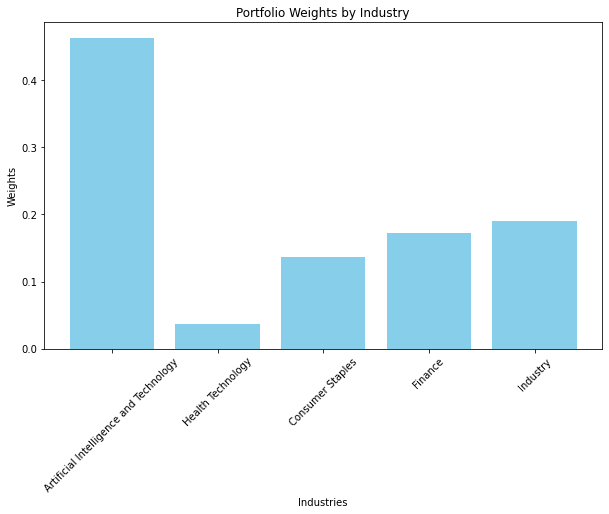

In [36]:
# Allocate weights based on normalized Sharpe Ratios
total_normalized_sharpe_ratios = np.sum(np.abs(list(normalized_sharpe_ratios.values())))
industry_weights = {industry: np.abs(normalized_sharpe_ratios[industry]) / total_normalized_sharpe_ratios for industry in normalized_sharpe_ratios}

print("Industry Weights:")
for industry, weight in industry_weights.items():
    print(f"{industry}: {weight:.4f}")

# Visualize the weights
import matplotlib.pyplot as plt

industries = list(industry_weights.keys())
weights = list(industry_weights.values())

plt.figure(figsize=(10, 6))
plt.bar(industries, weights, color='skyblue')
plt.xlabel('Industries')
plt.ylabel('Weights')
plt.title('Portfolio Weights by Industry')
plt.xticks(rotation=45)
plt.show()

<span style="color:blue; font-weight:bold; font-size:30px">Monte Carlo Simulation</span>

<span style="color: green; font-weight: bold; font-size: 18px;">I selected the top-ranked portfolio for the Monte Carlo Simulation.</span>

In [50]:
# Extract the top combination for debugging
top_combination_raw = top_20_combinations.iloc[0]['Stocks']
print("Raw Top Combination:", top_combination_raw)

# Clean the top combination to get stock symbols without extra characters
top_combination_cleaned = top_combination_raw.strip("[]()").replace("'", "").split(", ")
top_combination_cleaned = [stock.strip() for stock in top_combination_cleaned]
print("Cleaned Top Combination:", top_combination_cleaned)

# Check if each stock exists in returns_data
for stock in top_combination_cleaned:
    if stock not in returns_data:
        print(f"Stock {stock} not found in returns_data")
    else:
        print(f"Stock {stock} found in returns_data")

Raw Top Combination: ('AMZN', 'MDT', 'PEP', 'JPM', 'LMT')
Cleaned Top Combination: ['AMZN', 'MDT', 'PEP', 'JPM', 'LMT']
Stock AMZN found in returns_data
Stock MDT found in returns_data
Stock PEP found in returns_data
Stock JPM found in returns_data
Stock LMT found in returns_data


In [51]:
# Define the cleaned top combination
top_combination = ['AMZN', 'MDT', 'PEP', 'JPM', 'LMT']  # This should be cleaned from the previous step

# Load the returns data for the selected stocks
selected_returns_data = {stock: returns_data[stock] for stock in top_combination}

# Convert selected returns data to a DataFrame
selected_returns_df = pd.DataFrame(selected_returns_data)

# Perform Monte Carlo simulation
num_simulations = 10000
num_months = 12
simulated_returns = np.zeros((num_simulations, num_months))

# Generate random returns based on historical data
for i in range(num_simulations):
    simulated_returns[i, :] = selected_returns_df.sample(n=num_months, replace=True).mean(axis=1)

# Calculate the annualized return and volatility for each simulation
annualized_returns = np.mean(simulated_returns, axis=1) * 12
volatility = np.std(simulated_returns, axis=1) * np.sqrt(12)

# Calculate the Sharpe ratio for each simulation
risk_free_rate = 0.02
sharpe_ratios = (annualized_returns - risk_free_rate) / volatility

# Output results
print("Monte Carlo Simulation Results:")
print(f"Average Annual Return: {np.mean(annualized_returns):.4f}")
print(f"Average Volatility: {np.mean(volatility):.4f}")
print(f"Average Sharpe Ratio: {np.mean(sharpe_ratios):.4f}")

Monte Carlo Simulation Results:
Average Annual Return: 0.1344
Average Volatility: 0.1394
Average Sharpe Ratio: 0.9670


<span style="color: blue; font-weight: bold; font-size: 26px;">Final Evaluation and Comparison</span>

Top Combination: ('AMZN', 'MDT', 'PEP', 'JPM', 'LMT')
SPY Annual Return: 0.0056
SPY Volatility: 0.0384
SPY Sharpe Ratio: 0.1467
Monte Carlo Simulation Results:
Average Annual Return: 0.2092
Average Volatility: 0.1803
Average Sharpe Ratio: 1.1606


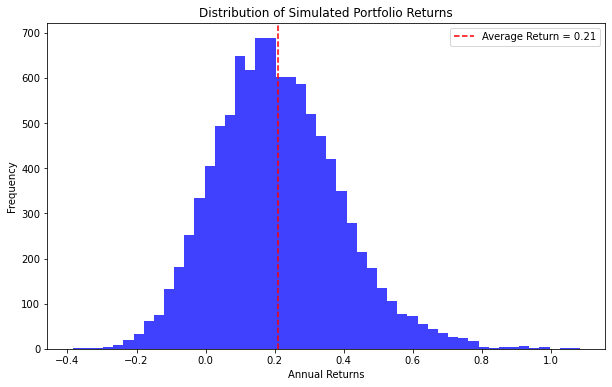

Comparison with SPY:
Optimized Portfolio - Average Annual Return: 0.2092
Optimized Portfolio - Volatility: 0.1803
Optimized Portfolio - Sharpe Ratio: 1.1606
SPY - Annual Return: 0.0056
SPY - Volatility: 0.0384
SPY - Sharpe Ratio: 0.1467


In [59]:


# Load the saved results
capm_df = pd.read_csv('capm_analysis_results.csv')
garch_df = pd.read_csv('garch_analysis_results.csv')
arima_df = pd.read_csv('arima_analysis_results.csv')

# Merge the results on the 'Stocks' column
merged_df = pd.merge(capm_df, garch_df, on='Stocks')
merged_df = pd.merge(merged_df, arima_df, on='Stocks')

# Calculate the final composite score
weights = {
    'Expected Annual Return': 0.5,
    'Average Volatility': -0.2,
    'ARIMA Prediction': 0.3
}

# Normalize the metrics for scoring
for metric in weights.keys():
    merged_df[f'{metric} Score'] = (merged_df[metric] - merged_df[metric].mean()) / merged_df[metric].std()

# Calculate the composite score
merged_df['Composite Score'] = sum(merged_df[f'{metric} Score'] * weight for metric, weight in weights.items())

# Sort stocks based on composite score
sorted_merged_df = merged_df.sort_values(by='Composite Score', ascending=False)

# Save the merged results to a CSV file
sorted_merged_df.to_csv('merged_analysis_results.csv', index=False)

# Print the top combination based on composite score
top_combination = eval(sorted_merged_df.iloc[0]['Stocks'])
print(f"Top Combination: {top_combination}")

# Load SPY returns and filter by date range
spy_returns = pd.read_csv('stock_data/SPY_data.csv', index_col=0, parse_dates=True)['SPY Return']
spy_returns = spy_returns[(spy_returns.index >= '2014-05-01') & (spy_returns.index <= '2024-04-30')]

# Calculate SPY metrics
spy_annual_return = (1 + spy_returns.mean()) ** 12 - 1
spy_volatility = spy_returns.std() * np.sqrt(12)
spy_sharpe_ratio = spy_annual_return / spy_volatility

print(f"SPY Annual Return: {spy_annual_return:.4f}")
print(f"SPY Volatility: {spy_volatility:.4f}")
print(f"SPY Sharpe Ratio: {spy_sharpe_ratio:.4f}")

# Load the returns data for the selected stocks
selected_returns_data = {stock.strip(): returns_data[stock.strip()] for stock in top_combination}

# Initialize the portfolio weights based on the calculated industry weights
portfolio_weights = np.array([industry_weights[industry] for industry in Selected_Stocks.keys() if any(stock in Selected_Stocks[industry] for stock in top_combination)])

# Ensure weights sum to 1 (normalize if necessary)
portfolio_weights = portfolio_weights / np.sum(portfolio_weights)

# Convert selected returns data to a DataFrame
portfolio_returns_df = pd.DataFrame(selected_returns_data)

# Calculate portfolio returns
portfolio_returns = portfolio_returns_df.dot(portfolio_weights)

# Monte Carlo Simulation
num_simulations = 10000
num_months = 12
simulation_results = []

for _ in range(num_simulations):
    simulated_returns = np.zeros(num_months)
    for stock, weight in zip(top_combination, portfolio_weights):
        # Generate random returns based on historical data
        stock_returns = selected_returns_data[stock.strip()]
        simulated_stock_returns = np.random.choice(stock_returns, num_months)
        # Weight the returns according to the portfolio weights
        simulated_returns += simulated_stock_returns * weight
    # Annualize the returns
    annual_simulated_return = (1 + simulated_returns.mean()) ** 12 - 1
    simulation_results.append(annual_simulated_return)

# Calculate statistics of the simulation results
average_return = np.mean(simulation_results)
volatility = np.std(simulation_results)
sharpe_ratio = average_return / volatility

print("Monte Carlo Simulation Results:")
print(f"Average Annual Return: {average_return:.4f}")
print(f"Average Volatility: {volatility:.4f}")
print(f"Average Sharpe Ratio: {sharpe_ratio:.4f}")

# Visualize the Monte Carlo simulation results
plt.figure(figsize=(10, 6))
plt.hist(simulation_results, bins=50, alpha=0.75, color='blue')
plt.axvline(x=average_return, color='red', linestyle='--', label=f'Average Return = {average_return:.2f}')
plt.title('Distribution of Simulated Portfolio Returns')
plt.xlabel('Annual Returns')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Comparison with SPY
print("Comparison with SPY:")
print(f"Optimized Portfolio - Average Annual Return: {average_return:.4f}")
print(f"Optimized Portfolio - Volatility: {volatility:.4f}")
print(f"Optimized Portfolio - Sharpe Ratio: {sharpe_ratio:.4f}")
print(f"SPY - Annual Return: {spy_annual_return:.4f}")
print(f"SPY - Volatility: {spy_volatility:.4f}")
print(f"SPY - Sharpe Ratio: {spy_sharpe_ratio:.4f}")

[*********************100%***********************]  1 of 1 completed
SPY Annual Return: 0.1425
SPY Volatility: 0.1752
SPY Sharpe Ratio: 0.8135
Monte Carlo Simulation Results:
Average Annual Return: 0.2091
Average Volatility: 0.1832
Average Sharpe Ratio: 1.1410


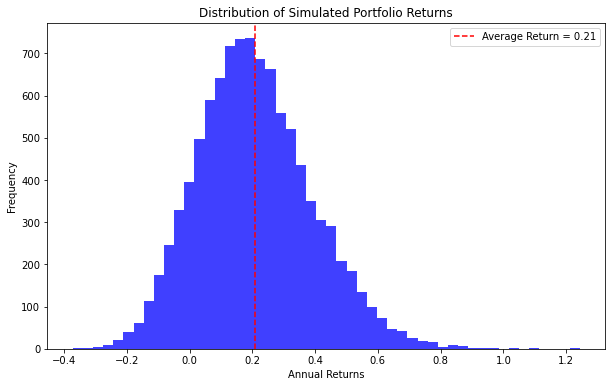

Comparison with SPY:
Optimized Portfolio - Average Annual Return: 0.2091
Optimized Portfolio - Volatility: 0.1832
Optimized Portfolio - Sharpe Ratio: 1.1410
SPY - Annual Return: 0.1425
SPY - Volatility: 0.1752
SPY - Sharpe Ratio: 0.8135


In [61]:
# Load the saved results
capm_df = pd.read_csv('capm_analysis_results.csv')
garch_df = pd.read_csv('garch_analysis_results.csv')
arima_df = pd.read_csv('arima_analysis_results.csv')

# Merge the results on the 'Stocks' column
merged_df = pd.merge(capm_df, garch_df, on='Stocks')
merged_df = pd.merge(merged_df, arima_df, on='Stocks')

# Calculate the final composite score
weights = {
    'Expected Annual Return': 0.5,
    'Average Volatility': -0.2,
    'ARIMA Prediction': 0.3
}

# Normalize the metrics for scoring
for metric in weights.keys():
    merged_df[f'{metric} Score'] = (merged_df[metric] - merged_df[metric].mean()) / merged_df[metric].std()

# Calculate the composite score
merged_df['Composite Score'] = sum(merged_df[f'{metric} Score'] * weight for metric, weight in weights.items())

# Sort stocks based on composite score
sorted_merged_df = merged_df.sort_values(by='Composite Score', ascending=False)

# Save the merged results to a CSV file
sorted_merged_df.to_csv('merged_analysis_results.csv', index=False)

# Print the top combination based on composite score
top_combination = eval(sorted_merged_df.iloc[0]['Stocks'])


#SPY
spy_data = yf.download('SPY', start='2014-05-01', end='2024-04-30')


spy_data['Daily Return'] = spy_data['Adj Close'].pct_change().dropna()


spy_annual_return = (1 + spy_data['Daily Return'].mean()) ** 252 - 1
spy_volatility = spy_data['Daily Return'].std() * np.sqrt(252)
spy_sharpe_ratio = spy_annual_return / spy_volatility

print(f"SPY Annual Return: {spy_annual_return:.4f}")
print(f"SPY Volatility: {spy_volatility:.4f}")
print(f"SPY Sharpe Ratio: {spy_sharpe_ratio:.4f}")

# Load the returns data for the selected stocks
selected_returns_data = {stock.strip(): returns_data[stock.strip()] for stock in top_combination}

# Initialize the portfolio weights based on the calculated industry weights
portfolio_weights = np.array([industry_weights[industry] for industry in Selected_Stocks.keys() if any(stock in Selected_Stocks[industry] for stock in top_combination)])

# Ensure weights sum to 1 (normalize if necessary)
portfolio_weights = portfolio_weights / np.sum(portfolio_weights)

# Convert selected returns data to a DataFrame
portfolio_returns_df = pd.DataFrame(selected_returns_data)

# Calculate portfolio returns
portfolio_returns = portfolio_returns_df.dot(portfolio_weights)

# Monte Carlo Simulation
num_simulations = 10000
num_months = 12
simulation_results = []

for _ in range(num_simulations):
    simulated_returns = np.zeros(num_months)
    for stock, weight in zip(top_combination, portfolio_weights):
        # Generate random returns based on historical data
        stock_returns = selected_returns_data[stock.strip()]
        simulated_stock_returns = np.random.choice(stock_returns, num_months)
        # Weight the returns according to the portfolio weights
        simulated_returns += simulated_stock_returns * weight
    # Annualize the returns
    annual_simulated_return = (1 + simulated_returns.mean()) ** 12 - 1
    simulation_results.append(annual_simulated_return)

# Calculate statistics of the simulation results
average_return = np.mean(simulation_results)
volatility = np.std(simulation_results)
sharpe_ratio = average_return / volatility

print("Monte Carlo Simulation Results:")
print(f"Average Annual Return: {average_return:.4f}")
print(f"Average Volatility: {volatility:.4f}")
print(f"Average Sharpe Ratio: {sharpe_ratio:.4f}")

# Visualize the Monte Carlo simulation results
plt.figure(figsize=(10, 6))
plt.hist(simulation_results, bins=50, alpha=0.75, color='blue')
plt.axvline(x=average_return, color='red', linestyle='--', label=f'Average Return = {average_return:.2f}')
plt.title('Distribution of Simulated Portfolio Returns')
plt.xlabel('Annual Returns')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Comparison with SPY
print("Comparison with SPY:")
print(f"Optimized Portfolio - Average Annual Return: {average_return:.4f}")
print(f"Optimized Portfolio - Volatility: {volatility:.4f}")
print(f"Optimized Portfolio - Sharpe Ratio: {sharpe_ratio:.4f}")
print(f"SPY - Annual Return: {spy_annual_return:.4f}")
print(f"SPY - Volatility: {spy_volatility:.4f}")
print(f"SPY - Sharpe Ratio: {spy_sharpe_ratio:.4f}")